In [1]:
#!jt -t oceans16 -f roboto -fs 12 -cellw 100%

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import xlsxwriter
from copy import copy
from sklearn import tree, metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import auc, roc_curve 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.discrete.discrete_model import Logit 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from varclushi import VarClusHi

In [3]:
#Important parameters
target_name='default_cross12'
time_name='period'
event_rate_name='BR'
event_name='Bad'
prob_event='PD'
nonevent_name='Good'
share_name='Share'
variable_name='Variable'
grp_name='GRP'
all_name='All'
logit_name='Logit'
condition_name='Condition'
time_report_name='Time'
intercept_name='Intercept'
score_name='Score'
beta_name='Beta'
fbeta_name='FBeta'
id_row='aid'
gini_train='Gini train'
gini_test='Gini test'
delta_gini='R. Gini'
estimation='Estimation'
pvalue='P-value'
max_pvalue='Max p-value'
max_vif='Max VIF'
max_con_index='Max Con Index'
max_pearson='Max Pearson'
nnegative_betas='N negative betas'
wald_test='Wald test'
degree_free='Degrees of freedom'
std_err='Standard error'
bad_share='Bad share'
good_share='Good share'
INV='Infomration Value'
PSI='Population Stability Index'
PSI_tar='Population Stability Index for bads'
share_name_test='Share test'
bad_share_test='Bad share test'
type_name='Type'
percent_missing='Missing percent'
count_unique='Number of distinct'
event_value='outstanding_bad'
all_value='outstanding'
event_rate_name_value='BRBal'
nonevent_name_value='Balance good'
share_name_value='Balance share'
mode_name='Mode'
mode_pname='P. mode'
type_name='Type'


#Bining for numerical variables
ncategories_int=5 #zmiana
minimum_share_int=0.03
symbol_missing='Missing'

#Bining for character variables
symbol_other='<OTHERS>'
#minimum share of unique value
minimum_share_unique=0.15
#minimum_share_unique=0.03 #zmiana
#maximal number of bins
ncategories_nom=3 #zmiana

#option for response model
# category_order=True
#option for risk model
category_order=False
description_results = ""
#description_results += "ncategories_nom=3; "

In [4]:
# ef = pd.ExcelFile('abt_app_PD_INS.xlsx')
# ef = pd.ExcelFile('abt_app.xls')
# df = ef.parse('Sheet1')

In [5]:
df = pd.read_sas('data/abt_app.sas7bdat', encoding='LATIN2')

In [6]:
print(type(df['app_char_job_code'][0]))
print(df['app_char_job_code'][0])

<class 'str'>
Retired


In [7]:
#df=df[('197501'<=df['period']) & (df['period']<='198712') & (df['product']=='css') & (df['decision']=='A')]
df=df[('197501'<=df['period']) & (df['period']<='198712') & (df['decision']=='A')]

In [8]:
df["app_char_job_code_home_status"] = df["app_char_job_code"] + df["app_char_home_status"]
df["app_char_marital_status_gender"] = df["app_char_marital_status"] + df["app_char_gender"]
df["app_char_city_gender"] = df["app_char_city"] + df["app_char_gender"]
df["app_char_marital_status_job_code"] = df["app_char_marital_status"] + df["app_char_job_code"]

In [9]:
df=df.drop(['app_char_job_code', 'app_char_marital_status', 'app_char_home_status', 'app_char_gender', 'app_char_branch'], axis=1)

In [10]:
df[intercept_name]=1
df[event_value]=df['app_loan_amount']*df[target_name]
df[all_value]=df['app_loan_amount']
df.head()

,cid,aid,product,period,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,...,default_cross12,cross_app_loan_amount,cross_app_n_installments,app_char_job_code_home_status,app_char_marital_status_gender,app_char_city_gender,app_char_marital_status_job_code,Intercept,outstanding_bad,outstanding
6597,0000000625,css1975010100063,css,197501,55.0,0.629712,1.583782,3157.0,5000.0,24.0,...,0.0,5000.0,24.0,PermanentOwner,MariedFemale,SmallFemale,MariedPermanent,1,0.0,5000.0
6598,0000001330,css1975010100098,css,197501,45.0,0.326905,1.530456,3267.0,5000.0,24.0,...,1.0,5000.0,24.0,PermanentOwner,MariedFemale,BigFemale,MariedPermanent,1,5000.0,5000.0
6599,0000002179,css1975010100120,css,197501,42.0,0.538908,2.903600,1722.0,5000.0,24.0,...,NaN,NaN,NaN,PermanentRental,MariedMale,BigMale,MariedPermanent,1,NaN,5000.0
6600,0000002366,css1975010100123,css,197501,70.0,0.559242,3.949447,1266.0,5000.0,24.0,...,0.0,5000.0,24.0,RetiredOwner,MariedFemale,MediumFemale,MariedRetired,1,0.0,5000.0
6601,0000000079,css1975010200009,css,197501,68.0,0.647492,3.344482,1495.0,5000.0,24.0,...,1.0,5000.0,24.0,RetiredOwner,WidowedMale,BigMale,WidowedRetired,1,5000.0,5000.0


In [11]:
df.shape 

(49224, 221)

In [12]:
#Do we have mising values in target variable?
one=df[target_name]
one[one.isnull()==True].head()

6599   NaN
6602   NaN
6604   NaN
6605   NaN
6607   NaN
Name: default_cross12, dtype: float64

In [13]:
#Dropping mising values in target variable
df_notempty=df.dropna(subset=[target_name])
one2=df_notempty[target_name]
one2[one2.isnull()==True].head()

Series([], Name: default_cross12, dtype: float64)

In [14]:
#List of variables
#description_results += " - vars  in ['app','act','agr','ags']- "
vars=[var for var in list(df) if var[0:3].lower() in ['app','act']]
#vars=[var for var in list(df) if var[0:3].lower() in ['app','act','agr','ags']] #zmiana
vars_target_id=vars+[target_name]+[time_name]+[intercept_name]+[event_value]+[all_value]+[id_row]
#vars_target_id

#splitting into numeric and character variables
varsc=list(df[vars].select_dtypes(include='object'))
varsn=list(df[vars].select_dtypes(include='number'))

print(varsc, varsn)
#vars_target_id

['app_char_city', 'app_char_cars', 'app_char_job_code_home_status', 'app_char_marital_status_gender', 'app_char_city_gender', 'app_char_marital_status_job_code'] ['act_age', 'act_cc', 'act_loaninc', 'app_income', 'app_loan_amount', 'app_n_installments', 'app_number_of_children', 'app_spendings', 'app_installment', 'act_call_cc', 'act_cins_n_loan', 'act_ccss_n_loan', 'act_call_n_loan', 'act_cins_seniority', 'act_cins_min_seniority', 'act_cins_n_loans_hist', 'act_cins_n_statC', 'act_cins_n_statB', 'act_cins_n_loans_act', 'act_cins_maxdue', 'act_cins_min_pninst', 'act_cins_min_lninst', 'act_cins_utl', 'act_cins_dueutl', 'act_cins_cc', 'act_ccss_seniority', 'act_ccss_min_seniority', 'act_ccss_n_loans_hist', 'act_ccss_n_statC', 'act_ccss_n_statB', 'act_ccss_n_loans_act', 'act_ccss_maxdue', 'act_ccss_min_pninst', 'act_ccss_min_lninst', 'act_ccss_utl', 'act_ccss_dueutl', 'act_ccss_cc', 'act_cus_active', 'act3_n_arrears', 'act3_n_arrears_days', 'act3_n_good_days', 'act6_n_arrears', 'act6_n_arr

In [15]:
#Splitting for train and test datasets
#from sklearn.model_selection import train_test_split
#description_results += " test_size=0.3; "
train, test = train_test_split(df_notempty[vars_target_id], random_state = 1234, test_size=0.3)
print(train.shape, test.shape)
train.head() 
#train[train[target_name].isnull()==True].head()
#test[test[target_name].isnull()==True].head()

(10486, 62) (4495, 62)


,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,app_char_city,...,app_char_job_code_home_status,app_char_marital_status_gender,app_char_city_gender,app_char_marital_status_job_code,default_cross12,period,Intercept,outstanding_bad,outstanding,aid
13393,48.0,0.387298,1.301406,3842.0,5000.0,24.0,1.0,1280.0,208.0,Big,...,PermanentRental,MariedFemale,BigFemale,MariedPermanent,1.0,197805,1,5000.0,5000.0,css1978051100147
27290,56.0,0.542208,4.058442,1232.0,5000.0,24.0,0.0,460.0,208.0,Large,...,RetiredOwner,MariedFemale,LargeFemale,MariedRetired,0.0,198506,1,0.0,5000.0,css1985061300025
22075,53.0,0.326905,1.530456,3267.0,5000.0,24.0,2.0,860.0,208.0,Big,...,PermanentOwner,MariedFemale,BigFemale,MariedPermanent,0.0,198209,1,0.0,5000.0,css1982091900076
19399,72.0,0.744444,13.888889,360.0,5000.0,24.0,1.0,60.0,208.0,Small,...,RetiredRental,WidowedFemale,SmallFemale,WidowedRetired,1.0,198105,1,5000.0,5000.0,css1981050700004
28844,66.0,0.426270,3.097893,1614.0,5000.0,24.0,0.0,480.0,208.0,Medium,...,RetiredOwner,WidowedFemale,MediumFemale,WidowedRetired,1.0,198604,1,5000.0,5000.0,css1986040700104


In [16]:
#Bining for numerical variables

# remove_list = []
labsn = {} # binns lists

for feature in varsn:
    #feature='app_income'
    miss_share=train[feature].isnull().sum()/train[feature].shape[0]
    miss_share=1-miss_share
    if miss_share<=0.00001:
        miss_share=1
    minimum_share=minimum_share_int/miss_share
    if minimum_share>0.5:
        minimum_share=0.5
    if minimum_share<minimum_share_int:
        minimum_share=minimum_share_int
    df_two_col=train[[target_name,feature]].dropna(subset=[feature]).copy()
    # binns list with [min,max]
    bins = [-np.inf, np.inf]
    # get Tree classifier - check if we need another parameters !!
    clf = tree.DecisionTreeClassifier(
        max_leaf_nodes=ncategories_int,
        min_weight_fraction_leaf=minimum_share,
        random_state=1234) 
    # fit tree
    clf.fit(df_two_col[feature].values.reshape(-1, 1), df_two_col[target_name])
    # get tresholds and remove empty
    thresh = [round(s, 3) for s in clf.tree_.threshold if s != -2]  
    # add tresholds to binns
    bins = bins + thresh 
    bins=sorted(bins)
    if train[feature].isnull().sum()/train[feature].shape[0] > minimum_share_int:
        bins=bins + [symbol_missing]
    labsn[feature]=bins
    
#labsn['app_number_of_children']=[-np.inf, 1, 2, np.inf]
#labsn['app_number_of_children']=[-np.inf, 1, 1, 2, np.inf] #todo
labsn #zmiana odkomentowane

{'act_age': [-inf, 45.5, 48.5, 52.5, 80.5, inf],
 'act_cc': [-inf, 0.347, 0.421, 0.516, 0.744, inf],
 'act_loaninc': [-inf, 1.076, 3.652, 4.293, 5.117, inf],
 'app_income': [-inf, 574.5, 643.5, 1063.0, 3833.0, inf],
 'app_loan_amount': [-inf, 2154.0, 4996.0, 5002.0, inf],
 'app_n_installments': [-inf, 18.0, 30.0, inf],
 'app_number_of_children': [-inf, 0.5, 1.5, 2.5, inf],
 'app_spendings': [-inf, 250.0, 430.0, 510.0, 870.0, inf],
 'app_installment': [-inf, 125.5, 207.5, 208.5, 312.0, inf],
 'act_call_cc': [-inf, 0.761, 1.254, 1.361, 1.581, inf],
 'act_cins_n_loan': [-inf, 0.5, 1.5, inf],
 'act_ccss_n_loan': [-inf, 0.5, 2.5, 4.5, 5.5, inf],
 'act_call_n_loan': [-inf, 1.5, 2.5, 5.5, 6.5, inf],
 'act_cins_seniority': [-inf, 59.5, 143.5, 181.5, 200.5, inf],
 'act_cins_min_seniority': [-inf, 16.5, 43.5, 55.5, 75.5, inf],
 'act_cins_n_loans_hist': [-inf, 2.5, 3.5, 4.5, 5.5, inf],
 'act_cins_n_statC': [-inf, 3.5, 4.5, 5.5, 7.5, inf],
 'act_cins_n_statB': [-inf, 0.5, 1.5, inf],
 'act_cins_n_l

In [17]:
train.groupby(feature).mean()

,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,act_call_cc,...,act6_n_good_days,act9_n_arrears,act9_n_arrears_days,act9_n_good_days,act12_n_arrears,act12_n_arrears_days,default_cross12,Intercept,outstanding_bad,outstanding
act12_n_good_days,,,,,,,,,,,,,,,,,,,,,
0.0,62.951020,0.587887,4.420788,1670.142857,4567.183673,22.089796,0.865306,633.306122,208.457143,1.006161,...,0.000000,4.069388,0.326531,0.000000,5.718367,0.436735,0.346939,1.0,1617.632653,4567.183673
1.0,65.090226,0.547004,4.156693,1684.195489,4947.105263,23.616541,1.131579,607.293233,209.488722,1.242735,...,0.518797,5.733083,0.697368,0.748120,7.571429,0.849624,0.426692,1.0,2134.255639,4947.105263
2.0,64.110749,0.544003,4.082420,1717.918567,4980.247557,23.830619,1.032573,611.921824,208.301846,1.194080,...,1.031488,6.825190,0.894680,1.476656,8.973941,1.097720,0.597177,1.0,2971.313789,4980.247557
3.0,64.820918,0.553634,4.039638,1724.781791,4951.015801,23.792325,0.942814,636.478555,207.252822,1.195011,...,1.601204,7.361174,0.900677,2.264108,9.594432,1.139202,0.696764,1.0,3462.314522,4951.015801
4.0,65.102181,0.578196,4.370731,1684.685358,4966.068536,23.805607,0.773209,638.940810,208.586293,1.223935,...,2.046106,7.556386,0.815576,2.977570,9.757009,1.003738,0.788785,1.0,3922.135826,4966.068536
5.0,64.469475,0.585103,4.535294,1624.874237,4992.078144,23.860806,0.728327,614.603175,209.341270,1.193211,...,2.501832,7.417582,0.663614,3.705128,9.525641,0.814408,0.851648,1.0,4257.147741,4992.078144
6.0,64.776224,0.605113,4.766425,1564.772028,4969.625175,23.874126,0.592308,605.762238,208.346154,1.196950,...,2.983916,6.982517,0.500000,4.413287,8.927273,0.613287,0.876224,1.0,4344.327273,4969.625175
7.0,64.304695,0.602459,4.753553,1610.781219,4980.247752,23.796204,0.556444,627.172827,208.996004,1.146882,...,3.516484,6.067932,0.301698,5.215784,7.789211,0.374625,0.870130,1.0,4337.346653,4980.247752
8.0,64.662045,0.624598,5.119385,1498.587522,4906.509532,23.604853,0.528596,586.932409,207.809359,1.168050,...,3.958406,5.197574,0.187175,5.883882,6.623917,0.225303,0.840555,1.0,4161.303293,4906.509532


In [18]:
varsc

['app_char_city',
 'app_char_cars',
 'app_char_job_code_home_status',
 'app_char_marital_status_gender',
 'app_char_city_gender',
 'app_char_marital_status_job_code']

In [19]:
#Bining for character variables

#from sklearn.cluster import AgglomerativeClustering
# remove_list = []
labsc = {} # binns lists

for feature in varsc:
    print("--------------------------", feature, "--------------------------") 
    df_two_col1=pd.DataFrame(train.groupby(feature)[target_name].count()/train.shape[0])
    print("df_two_col1", df_two_col1.head())
    df_two_col2=pd.DataFrame(train.groupby(feature)[target_name].mean())
    print("-----------------------------------------------------------------------------------------------df_two_col2\n", df_two_col2.head())
    df_two_col=df_two_col2
    df_two_col['share']=df_two_col1[target_name]
    df_two_col = df_two_col.loc[df_two_col['share'] > minimum_share_unique]
    ncategoriesv = min(ncategories_nom, df_two_col.shape[0])
    print("-----------------------------------------------------------------------------------------------ncategoriesv\n", ncategoriesv)
    if ncategoriesv >= 2:
        #zmiana affinity='euclidean'
        cluster = AgglomerativeClustering(n_clusters=ncategoriesv, affinity='euclidean', linkage='ward')
        cluster.fit_predict(df_two_col[[target_name]])
        #zmiana - A value is trying to be set on a copy of a slice from a DataFrame.
        #df_two_col['cluster']= cluster.labels_.reshape(-1,1)
        df_two_col.loc[:, 'cluster'] = cluster.labels_.reshape(-1,1)

        print("-----------------------------------------------------------------------------------------------cluster\n", cluster, df_two_col.head(3))
    else:
        #zmiana
        df_two_col['cluster'] = 0
        #df_two_col.loc[:, 'cluster'] = 0
       #df_two_col.loc.__setitem__((slice(None), 'cluster'), 0)
        
    bins = df_two_col[['cluster']]
    if df_two_col['share'].sum() < (1-minimum_share_unique):
        bins.loc[symbol_other]=-1
        bins['cluster']=bins['cluster']+1
    print("-----------------------------------------------------------------------------------------------bins\n", bins)
    bins=bins.sort_values(by='cluster')
    bins=bins.reset_index()
    labsc[feature]=bins
    print("-----------------------------------------------------------------------------------------------bins\n", bins)
#zmiana 
#vars 
    
labsc

-------------------------- app_char_city --------------------------
df_two_col1                default_cross12
app_char_city                 
Big                   0.342552
Large                 0.145146
Medium                0.331966
Small                 0.180336
-----------------------------------------------------------------------------------------------df_two_col2
                default_cross12
app_char_city                 
Big                   0.704900
Large                 0.704336
Medium                0.749210
Small                 0.709677
-----------------------------------------------------------------------------------------------ncategoriesv
 3
-----------------------------------------------------------------------------------------------cluster
 AgglomerativeClustering(n_clusters=3)                default_cross12     share  cluster
app_char_city                                    
Big                   0.704900  0.342552        2
Medium                0.749210  0.331

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_3096/3947812460.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_two_col.loc[:, 'cluster'] = cluster.labels_.reshape(-1,1)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_3096/3947812460.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_two_col['cluster'] = 0
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_3096/3947812460.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

{'app_char_city':   app_char_city  cluster
 0         Small        0
 1        Medium        1
 2           Big        2,
 'app_char_cars':   app_char_cars  cluster
 0         Owner        0,
 'app_char_job_code_home_status':   app_char_job_code_home_status  cluster
 0                      <OTHERS>        0
 1                  RetiredOwner        1
 2                PermanentOwner        2,
 'app_char_marital_status_gender':   app_char_marital_status_gender  cluster
 0                       <OTHERS>        0
 1                  WidowedFemale        1
 2                 DivorcedFemale        2
 3                   MariedFemale        3,
 'app_char_city_gender':   app_char_city_gender  cluster
 0             <OTHERS>        0
 1         MediumFemale        1
 2            BigFemale        2,
 'app_char_marital_status_job_code':   app_char_marital_status_job_code  cluster
 0                  MariedPermanent        0
 1                    MariedRetired        0
 2                  Divorced

In [20]:
train["app_char_cars"].unique()

array(['Owner', 'No'], dtype=object)

In [21]:
varsc

['app_char_city',
 'app_char_cars',
 'app_char_job_code_home_status',
 'app_char_marital_status_gender',
 'app_char_city_gender',
 'app_char_marital_status_job_code']

In [22]:
labsc.keys()

dict_keys(['app_char_city', 'app_char_cars', 'app_char_job_code_home_status', 'app_char_marital_status_gender', 'app_char_city_gender', 'app_char_marital_status_job_code'])

In [23]:
#Creating GRP variables for numerical variables
feature_intervalsn = {}
for feature in varsn:
    intervals = []
    tekst=''
    for i in range(len(labsn[feature])):
        if i==0 and labsn[feature][i]==-np.inf and labsn[feature][i+1]!=np.inf:
            tekst=feature+' < '+str(labsn[feature][i+1])
            intervals=intervals + [tekst]        
        if i==0 and labsn[feature][i]==-np.inf and labsn[feature][i+1]==np.inf:
            tekst=feature+' <> '+symbol_missing
            intervals=intervals + [tekst]        
        if i>0 and labsn[feature][i-1]!=-np.inf and labsn[feature][i]==np.inf:
            tekst=str(labsn[feature][i-1])+' <= '+feature
            intervals=intervals + [tekst]        
        if i>0 and labsn[feature][i-1]!=-np.inf and labsn[feature][i]!=np.inf and labsn[feature][i]!=symbol_missing:
            tekst=str(labsn[feature][i-1])+' <= '+feature+' < '+str(labsn[feature][i])
            intervals=intervals + [tekst]        
        if labsn[feature][i]==symbol_missing:
            tekst=feature+' = '+symbol_missing
            intervals=intervals + [tekst]
    feature_intervalsn[feature]=intervals
        
feature_intervalsn

{'act_age': ['act_age < 45.5',
  '45.5 <= act_age < 48.5',
  '48.5 <= act_age < 52.5',
  '52.5 <= act_age < 80.5',
  '80.5 <= act_age'],
 'act_cc': ['act_cc < 0.347',
  '0.347 <= act_cc < 0.421',
  '0.421 <= act_cc < 0.516',
  '0.516 <= act_cc < 0.744',
  '0.744 <= act_cc'],
 'act_loaninc': ['act_loaninc < 1.076',
  '1.076 <= act_loaninc < 3.652',
  '3.652 <= act_loaninc < 4.293',
  '4.293 <= act_loaninc < 5.117',
  '5.117 <= act_loaninc'],
 'app_income': ['app_income < 574.5',
  '574.5 <= app_income < 643.5',
  '643.5 <= app_income < 1063.0',
  '1063.0 <= app_income < 3833.0',
  '3833.0 <= app_income'],
 'app_loan_amount': ['app_loan_amount < 2154.0',
  '2154.0 <= app_loan_amount < 4996.0',
  '4996.0 <= app_loan_amount < 5002.0',
  '5002.0 <= app_loan_amount'],
 'app_n_installments': ['app_n_installments < 18.0',
  '18.0 <= app_n_installments < 30.0',
  '30.0 <= app_n_installments'],
 'app_number_of_children': ['app_number_of_children < 0.5',
  '0.5 <= app_number_of_children < 1.5',
 

In [24]:
#Creating GRP variables for character variables
feature_intervalsc = {}
for feature in varsc:
    intervals = []
    tekst=''
    for i in range(labsc[feature].shape[0]):
        if i==0:
            tekst=labsc[feature][feature][i]
        if i>0:
            if labsc[feature]['cluster'][i-1]==labsc[feature]['cluster'][i]:
                tekst=tekst+', '+labsc[feature][feature][i]
            else:
                intervals=intervals + [tekst]
                tekst=labsc[feature][feature][i]
        if i+1==labsc[feature].shape[0]:
            intervals=intervals + [tekst]
                    
    feature_intervalsc[feature]=intervals
        
feature_intervalsc

{'app_char_city': ['Small', 'Medium', 'Big'],
 'app_char_cars': ['Owner'],
 'app_char_job_code_home_status': ['<OTHERS>',
  'RetiredOwner',
  'PermanentOwner'],
 'app_char_marital_status_gender': ['<OTHERS>',
  'WidowedFemale',
  'DivorcedFemale',
  'MariedFemale'],
 'app_char_city_gender': ['<OTHERS>', 'MediumFemale', 'BigFemale'],
 'app_char_marital_status_job_code': ['MariedPermanent, MariedRetired',
  'DivorcedRetired',
  'WidowedRetired']}

In [25]:
#Creating GRP variables in train dataset
train_grp=train.copy()
nnn=0
for feature in varsn:
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=np.NaN
        for i in range(len(labsn[feature])):
            if i==0 and labsn[feature][i]==-np.inf and labsn[feature][i+1]!=np.inf and x<labsn[feature][i+1]:                
                    res=i            
            if i==0 and labsn[feature][i]==-np.inf and labsn[feature][i+1]==np.inf and (-np.inf<=x<=np.inf):            
                    res=i
            if i>0 and labsn[feature][i-1]!=-np.inf and labsn[feature][i]==np.inf and labsn[feature][i-1]<=x:            
                    res=i-1
            if i>0 and labsn[feature][i-1]!=-np.inf and labsn[feature][i]!=np.inf and labsn[feature][i]!=symbol_missing and labsn[feature][i-1]<=x<labsn[feature][i+1]:        
                    res=i-1
            if labsn[feature][i]==symbol_missing and math.isnan(x):
                    res=i-1
        return res
    train_grp[feature]=train_grp[feature].apply(grp)
    
for feature in varsc:
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=np.NaN
        if type(x) != str:
            x=str('')
        if labsc[feature][feature][0]==symbol_other:
            res=0
        for i in range(labsc[feature].shape[0]):
            if x==labsc[feature][feature][i] and labsc[feature][feature][i]!=symbol_other:
                res=labsc[feature]['cluster'][i]
        return res
    train_grp[feature]=train_grp[feature].apply(grp)
    
train_grp.head()

1 act_age
2 act_cc
3 act_loaninc
4 app_income
5 app_loan_amount
6 app_n_installments
7 app_number_of_children
8 app_spendings
9 app_installment
10 act_call_cc
11 act_cins_n_loan
12 act_ccss_n_loan
13 act_call_n_loan
14 act_cins_seniority
15 act_cins_min_seniority
16 act_cins_n_loans_hist
17 act_cins_n_statC
18 act_cins_n_statB
19 act_cins_n_loans_act
20 act_cins_maxdue
21 act_cins_min_pninst
22 act_cins_min_lninst
23 act_cins_utl
24 act_cins_dueutl
25 act_cins_cc
26 act_ccss_seniority
27 act_ccss_min_seniority
28 act_ccss_n_loans_hist
29 act_ccss_n_statC
30 act_ccss_n_statB
31 act_ccss_n_loans_act
32 act_ccss_maxdue
33 act_ccss_min_pninst
34 act_ccss_min_lninst
35 act_ccss_utl
36 act_ccss_dueutl
37 act_ccss_cc
38 act_cus_active
39 act3_n_arrears
40 act3_n_arrears_days
41 act3_n_good_days
42 act6_n_arrears
43 act6_n_arrears_days
44 act6_n_good_days
45 act9_n_arrears
46 act9_n_arrears_days
47 act9_n_good_days
48 act12_n_arrears
49 act12_n_arrears_days
50 act12_n_good_days
51 app_char_cit

,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,app_char_city,...,app_char_job_code_home_status,app_char_marital_status_gender,app_char_city_gender,app_char_marital_status_job_code,default_cross12,period,Intercept,outstanding_bad,outstanding,aid
13393,1,1,1,4,2,1,1,4,2,2.0,...,0,3,2,0.0,1.0,197805,1,5000.0,5000.0,css1978051100147
27290,3,3,2,3,2,1,0,2,2,NaN,...,1,3,0,0.0,0.0,198506,1,0.0,5000.0,css1985061300025
22075,3,0,1,3,2,1,2,3,2,2.0,...,2,3,2,0.0,0.0,198209,1,0.0,5000.0,css1982091900076
19399,3,4,4,0,2,1,1,0,2,0.0,...,0,1,0,2.0,1.0,198105,1,5000.0,5000.0,css1981050700004
28844,3,2,1,3,2,1,0,2,2,1.0,...,1,1,1,2.0,1.0,198604,1,5000.0,5000.0,css1986040700104


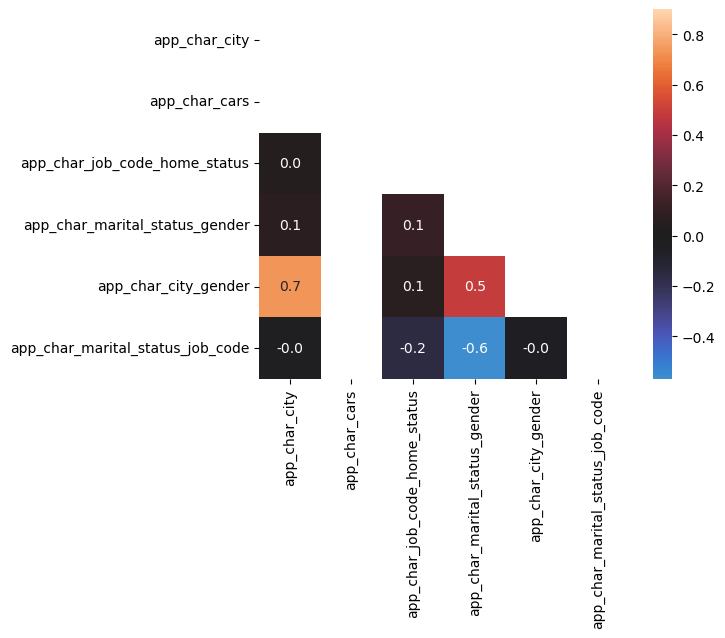

In [26]:
#plt.subplots(figsize=(20, 10))
#corr_df=df.corr()
#heatmap_df = corr_df.drop(varsn).drop(varsn,axis=1)
# Generate a mask for the upper triangle
corr = train_grp[varsc].dropna()
corr = corr.corr()
mask = np.zeros_like(corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, vmax=.9, square=True, annot=True, fmt='.1f', center=0)
#sns.heatmap(df.corr(), vmax=.9, square=True, annot=True, fmt='.1f', center=0)
plt.show()
#check

In [27]:
#Creating Big_scorecard
Big_scorecard=pd.DataFrame()
sum=train_grp.shape[0]
sum_bad=train_grp[target_name].sum()
sum_good=sum-sum_bad

for feature in varsn:
    fin=pd.DataFrame()
    sss=pd.DataFrame()
    ddd=pd.DataFrame()
    sss=pd.DataFrame(train_grp.groupby(feature).agg({target_name:['sum','count']}))
    sss=pd.DataFrame(sss[target_name])
    sss=sss.reset_index()
    sss=sss.rename(columns={"sum": event_name, "count": all_name, feature:grp_name})
    sss[nonevent_name]=sss[all_name]-sss[event_name]
    sss[event_rate_name]=sss[event_name]/sss[all_name]
    sss[logit_name]=np.log((sss[event_name]+0.0001) / (sss[nonevent_name]+0.0001))
    sss[share_name]=sss[all_name]/sum
    sss[variable_name]=feature    
    ddd=pd.DataFrame({grp_name:range(len(feature_intervalsn[feature])),condition_name:feature_intervalsn[feature]})
    fin=pd.merge(ddd, sss, on=grp_name)
    fin=fin[[variable_name,condition_name,event_rate_name,share_name,all_name,event_name,nonevent_name,logit_name,grp_name]]
    fin=fin.sort_values(by=[event_rate_name],ascending=category_order)
    fin=fin.reset_index(drop=True)
    fin[grp_name]=fin.index
    fin[type_name]='INT'
    #zmiana
    #Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
    Big_scorecard = pd.concat([Big_scorecard, fin], ignore_index=True, sort=False)
    
for feature in varsc:
    fin=pd.DataFrame()
    sss=pd.DataFrame()
    ddd=pd.DataFrame()
    sss=pd.DataFrame(train_grp.groupby(feature).agg({target_name:['sum','count']}))
    sss=pd.DataFrame(sss[target_name])
    sss=sss.reset_index()
    sss=sss.rename(columns={"sum": event_name, "count": all_name, feature:grp_name})
    sss[nonevent_name]=sss[all_name]-sss[event_name]
    sss[event_rate_name]=sss[event_name]/sss[all_name]
    sss[logit_name]=np.log((sss[event_name]+0.0001) / (sss[nonevent_name]+0.0001))
    sss[share_name]=sss[all_name]/sum
    sss[variable_name]=feature    
    ddd=pd.DataFrame({grp_name:range(len(feature_intervalsc[feature])),condition_name:feature_intervalsc[feature]})
    fin=pd.merge(ddd, sss, on=grp_name)
    fin=fin[[variable_name,condition_name,event_rate_name,share_name,all_name,event_name,nonevent_name,logit_name,grp_name]]
    fin=fin.sort_values(by=[event_rate_name],ascending=category_order)
    fin=fin.reset_index(drop=True)
    fin[grp_name]=fin.index
    fin[type_name]='NOM'
    #zmiana
    #Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
    Big_scorecard = pd.concat([Big_scorecard, fin], ignore_index=True, sort=False)

Big_scorecard[bad_share]=Big_scorecard[event_name]/sum_bad
Big_scorecard[good_share]=Big_scorecard[nonevent_name]/sum_good
Big_scorecard[INV]=(Big_scorecard[good_share]-Big_scorecard[bad_share])*np.log((Big_scorecard[good_share]+0.0001) / (Big_scorecard[bad_share]+0.0001))
Big_scorecard.to_excel('Big_scorecard.xlsx', index=False)    
Big_scorecard.head()

,Variable,Condition,BR,Share,All,Bad,Good,Logit,GRP,Type,Bad share,Good share,Infomration Value
0,act_age,48.5 <= act_age < 52.5,0.767538,0.069331,727,558.0,169.0,1.194460,0,INT,0.073868,0.057640,0.004020
1,act_age,act_age < 45.5,0.735562,0.031375,329,242.0,87.0,1.023029,1,INT,0.032036,0.029673,0.000181
2,act_age,52.5 <= act_age < 80.5,0.725901,0.796395,8351,6062.0,2289.0,0.973925,2,INT,0.802489,0.780696,0.000600
3,act_age,45.5 <= act_age < 48.5,0.665672,0.031947,335,223.0,112.0,0.688672,3,INT,0.029521,0.038199,0.002230
4,act_age,80.5 <= act_age,0.630376,0.070952,744,469.0,275.0,0.533832,4,INT,0.062086,0.093793,0.013064


In [28]:
#Creating grp_train and grp_test
#feature='app_income'
nnn=0
grp_train=train.copy() 
grp_test=test.copy()
#grp_train=train_grp.copy()
#grp_test=test.copy()
for feature in varsn:
    sub=pd.DataFrame()
    sub=Big_scorecard[Big_scorecard[variable_name]==feature]
    sub=sub.reset_index()
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=sub[grp_name][0]            
        for i in range(sub.shape[0]):
            sl=-np.inf
            sr=np.inf
            fl=sub[condition_name][i].find(' <= ')
            fr=sub[condition_name][i].find(' < ')
            if fl>=0:
                sl=float(sub[condition_name][i][0:fl])
            if fr>=0:
                sr=float(sub[condition_name][i][fr+3:])
            #fnm=condition_name][i].find(' <> '+symbol_missing)
            fm=sub[condition_name][i].find(' = '+symbol_missing) 
            if fm>=0 and math.isnan(x):                
                    res=sub[grp_name][i]            
            if fm<0 and (sl <= x < sr):                
                    res=sub[grp_name][i] 
        return res
    grp_train[feature]=grp_train[feature].apply(grp)
    grp_test[feature]=grp_test[feature].apply(grp)

for feature in varsc:
    sub=pd.DataFrame()
    sub=Big_scorecard[Big_scorecard[variable_name]==feature]
    sub=sub.reset_index()
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=sub[grp_name][0] 
        if type(x) != str:
            x=str('')
        for i in range(sub.shape[0]):
            fo=sub[condition_name][i].find(symbol_other)
            if fo>=0:                
                    res=sub[grp_name][i]            
        for i in range(sub.shape[0]):
            fo=sub[condition_name][i].find(symbol_other)
            if fo<0 and sub[condition_name][i].find(x)>=0:                
                    res=sub[grp_name][i] 
        return res
    grp_train[feature]=grp_train[feature].apply(grp)
    grp_test[feature]=grp_test[feature].apply(grp)
    
    
grp_train.head() #moze to do 

1 act_age
2 act_cc
3 act_loaninc
4 app_income
5 app_loan_amount
6 app_n_installments
7 app_number_of_children
8 app_spendings
9 app_installment
10 act_call_cc
11 act_cins_n_loan
12 act_ccss_n_loan
13 act_call_n_loan
14 act_cins_seniority
15 act_cins_min_seniority
16 act_cins_n_loans_hist
17 act_cins_n_statC
18 act_cins_n_statB
19 act_cins_n_loans_act
20 act_cins_maxdue
21 act_cins_min_pninst
22 act_cins_min_lninst
23 act_cins_utl
24 act_cins_dueutl
25 act_cins_cc
26 act_ccss_seniority
27 act_ccss_min_seniority
28 act_ccss_n_loans_hist
29 act_ccss_n_statC
30 act_ccss_n_statB
31 act_ccss_n_loans_act
32 act_ccss_maxdue
33 act_ccss_min_pninst
34 act_ccss_min_lninst
35 act_ccss_utl
36 act_ccss_dueutl
37 act_ccss_cc
38 act_cus_active
39 act3_n_arrears
40 act3_n_arrears_days
41 act3_n_good_days
42 act6_n_arrears
43 act6_n_arrears_days
44 act6_n_good_days
45 act9_n_arrears
46 act9_n_arrears_days
47 act9_n_good_days
48 act12_n_arrears
49 act12_n_arrears_days
50 act12_n_good_days
51 app_char_cit

,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,app_char_city,...,app_char_job_code_home_status,app_char_marital_status_gender,app_char_city_gender,app_char_marital_status_job_code,default_cross12,period,Intercept,outstanding_bad,outstanding,aid
13393,3,4,2,1,0,0,1,1,0,2,...,2,2,2,1,1.0,197805,1,5000.0,5000.0,css1978051100147
27290,2,1,1,3,0,0,0,4,0,0,...,0,2,1,1,0.0,198506,1,0.0,5000.0,css1985061300025
22075,2,2,2,3,0,0,2,2,0,2,...,1,2,2,1,0.0,198209,1,0.0,5000.0,css1982091900076
19399,2,0,0,0,0,0,1,0,0,1,...,2,3,1,2,1.0,198105,1,5000.0,5000.0,css1981050700004
28844,2,3,2,3,0,0,0,4,0,0,...,0,3,0,2,1.0,198604,1,5000.0,5000.0,css1986040700104


In [29]:
#Creating grp_train and grp_test
#feature='app_income'
nnn=0
grp_train=train.copy()
grp_test=test.copy()
for feature in varsn:
    sub=pd.DataFrame()
    sub=Big_scorecard[Big_scorecard[variable_name]==feature]
    sub=sub.reset_index()
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=sub[grp_name][0]            
        for i in range(sub.shape[0]):
            sl=-np.inf
            sr=np.inf
            fl=sub[condition_name][i].find(' <= ')
            fr=sub[condition_name][i].find(' < ')
            if fl>=0:
                sl=float(sub[condition_name][i][0:fl])
            if fr>=0:
                sr=float(sub[condition_name][i][fr+3:])
            #fnm=condition_name][i].find(' <> '+symbol_missing)
            fm=sub[condition_name][i].find(' = '+symbol_missing)
            if fm>=0 and math.isnan(x):                
                    res=sub[grp_name][i]            
            if fm<0 and (sl <= x < sr):                
                    res=sub[grp_name][i] 
        return res
    grp_train[feature]=grp_train[feature].apply(grp)
    grp_test[feature]=grp_test[feature].apply(grp)

for feature in varsc:
    sub=pd.DataFrame()
    sub=Big_scorecard[Big_scorecard[variable_name]==feature]
    sub=sub.reset_index()
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=sub[grp_name][0] 
        if type(x) != str:
            x=str('')
        for i in range(sub.shape[0]):
            fo=sub[condition_name][i].find(symbol_other)
            if fo>=0:                
                    res=sub[grp_name][i]            
        for i in range(sub.shape[0]):
            fo=sub[condition_name][i].find(symbol_other)
            if fo<0 and sub[condition_name][i].find(x)>=0:                
                    res=sub[grp_name][i] 
        return res
    grp_train[feature]=grp_train[feature].apply(grp)
    grp_test[feature]=grp_test[feature].apply(grp)
    
    
grp_train.head()

1 act_age
2 act_cc
3 act_loaninc
4 app_income
5 app_loan_amount
6 app_n_installments
7 app_number_of_children
8 app_spendings
9 app_installment
10 act_call_cc
11 act_cins_n_loan
12 act_ccss_n_loan
13 act_call_n_loan
14 act_cins_seniority
15 act_cins_min_seniority
16 act_cins_n_loans_hist
17 act_cins_n_statC
18 act_cins_n_statB
19 act_cins_n_loans_act
20 act_cins_maxdue
21 act_cins_min_pninst
22 act_cins_min_lninst
23 act_cins_utl
24 act_cins_dueutl
25 act_cins_cc
26 act_ccss_seniority
27 act_ccss_min_seniority
28 act_ccss_n_loans_hist
29 act_ccss_n_statC
30 act_ccss_n_statB
31 act_ccss_n_loans_act
32 act_ccss_maxdue
33 act_ccss_min_pninst
34 act_ccss_min_lninst
35 act_ccss_utl
36 act_ccss_dueutl
37 act_ccss_cc
38 act_cus_active
39 act3_n_arrears
40 act3_n_arrears_days
41 act3_n_good_days
42 act6_n_arrears
43 act6_n_arrears_days
44 act6_n_good_days
45 act9_n_arrears
46 act9_n_arrears_days
47 act9_n_good_days
48 act12_n_arrears
49 act12_n_arrears_days
50 act12_n_good_days
51 app_char_cit

,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,app_char_city,...,app_char_job_code_home_status,app_char_marital_status_gender,app_char_city_gender,app_char_marital_status_job_code,default_cross12,period,Intercept,outstanding_bad,outstanding,aid
13393,3,4,2,1,0,0,1,1,0,2,...,2,2,2,1,1.0,197805,1,5000.0,5000.0,css1978051100147
27290,2,1,1,3,0,0,0,4,0,0,...,0,2,1,1,0.0,198506,1,0.0,5000.0,css1985061300025
22075,2,2,2,3,0,0,2,2,0,2,...,1,2,2,1,0.0,198209,1,0.0,5000.0,css1982091900076
19399,2,0,0,0,0,0,1,0,0,1,...,2,3,1,2,1.0,198105,1,5000.0,5000.0,css1981050700004
28844,2,3,2,3,0,0,0,4,0,0,...,0,3,0,2,1.0,198604,1,5000.0,5000.0,css1986040700104


In [30]:
#Creating Big_scorecard test
Big_scorecard_test=pd.DataFrame()
sum=grp_test.shape[0]
sum_bad=grp_test[target_name].sum()

for feature in vars:
    sss=pd.DataFrame()
    sss=pd.DataFrame(grp_test.groupby(feature).agg({target_name:['sum','count']}))
    sss=pd.DataFrame(sss[target_name])
    sss=sss.reset_index()
    sss=sss.rename(columns={"sum": event_name, "count": all_name, feature:grp_name})
    sss[nonevent_name]=sss[all_name]-sss[event_name]
    sss[share_name_test]=sss[all_name]/sum
    sss[bad_share_test]=sss[event_name]/sum_bad
    sss[variable_name]=feature
    sss=sss[[variable_name,grp_name,share_name_test,bad_share_test]]
    #zmiana
    #Big_scorecard_test=Big_scorecard_test.append(sss,ignore_index=True, sort=False)
    Big_scorecard_test = pd.concat([Big_scorecard_test, sss], ignore_index=True, sort=False)
    

Big_scorecard_test.head()

,Variable,GRP,Share test,Bad share test
0,act_age,0,0.065184,0.072308
1,act_age,1,0.030701,0.031077
2,act_age,2,0.802225,0.799692
3,act_age,3,0.032258,0.030154
4,act_age,4,0.069633,0.066769


In [31]:
Big_scorecard

,Variable,Condition,BR,Share,All,Bad,Good,Logit,GRP,Type,Bad share,Good share,Infomration Value
0,act_age,48.5 <= act_age < 52.5,0.767538,0.069331,727,558.0,169.0,1.194460,0,INT,0.073868,0.057640,0.004020
1,act_age,act_age < 45.5,0.735562,0.031375,329,242.0,87.0,1.023029,1,INT,0.032036,0.029673,0.000181
2,act_age,52.5 <= act_age < 80.5,0.725901,0.796395,8351,6062.0,2289.0,0.973925,2,INT,0.802489,0.780696,0.000600
3,act_age,45.5 <= act_age < 48.5,0.665672,0.031947,335,223.0,112.0,0.688672,3,INT,0.029521,0.038199,0.002230
4,act_age,80.5 <= act_age,0.630376,0.070952,744,469.0,275.0,0.533832,4,INT,0.062086,0.093793,0.013064
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,app_char_city_gender,<OTHERS>,0.727830,0.466718,4894,3562.0,1332.0,0.983641,1,NOM,0.471538,0.454297,0.000642
260,app_char_city_gender,BigFemale,0.693778,0.274366,2877,1996.0,881.0,0.817843,2,NOM,0.264231,0.300477,0.004658
261,app_char_marital_status_job_code,DivorcedRetired,0.787601,0.176903,1855,1461.0,394.0,1.310525,0,NOM,0.193407,0.134379,0.021481
262,app_char_marital_status_job_code,"MariedPermanent, MariedRetired",0.702663,0.454797,4769,3351.0,1418.0,0.860011,1,NOM,0.443606,0.483629,0.003456


In [32]:
#calculating PSI INV
Big_scorecard=pd.merge(Big_scorecard, Big_scorecard_test, on=[variable_name,grp_name], how='left')
Big_scorecard[PSI]=(Big_scorecard[share_name]-Big_scorecard[share_name_test])*np.log((Big_scorecard[share_name]+0.0001) / (Big_scorecard[share_name_test]+0.0001))
Big_scorecard[PSI_tar]=(Big_scorecard[bad_share]-Big_scorecard[bad_share_test])*np.log((Big_scorecard[bad_share]+0.0001) / (Big_scorecard[bad_share_test]+0.0001))

Big_scorecard.head()

,Variable,Condition,BR,Share,All,Bad,Good,Logit,GRP,Type,Bad share,Good share,Infomration Value,Share test,Bad share test,Population Stability Index,Population Stability Index for bads
0,act_age,48.5 <= act_age < 52.5,0.767538,0.069331,727,558.0,169.0,1.194460,0,INT,0.073868,0.057640,0.004020,0.065184,0.072308,0.000255,0.000033
1,act_age,act_age < 45.5,0.735562,0.031375,329,242.0,87.0,1.023029,1,INT,0.032036,0.029673,0.000181,0.030701,0.031077,0.000015,0.000029
2,act_age,52.5 <= act_age < 80.5,0.725901,0.796395,8351,6062.0,2289.0,0.973925,2,INT,0.802489,0.780696,0.000600,0.802225,0.799692,0.000043,0.000010
3,act_age,45.5 <= act_age < 48.5,0.665672,0.031947,335,223.0,112.0,0.688672,3,INT,0.029521,0.038199,0.002230,0.032258,0.030154,0.000003,0.000013
4,act_age,80.5 <= act_age,0.630376,0.070952,744,469.0,275.0,0.533832,4,INT,0.062086,0.093793,0.013064,0.069633,0.066769,0.000025,0.000340


In [33]:
# #zmiana
# def grp(x):
#     res=sub[logit_name][0]
#     fm=None
#     for i in range(sub.shape[0]):
#         sl=-np.inf
#         sr=np.inf
#         fl=sub[condition_name][i].find(' <= ')
#         fr=sub[condition_name][i].find(' < ')
#         if fl>=0:
#             sl=float(sub[condition_name][i][0:fl])
#         if fr>=0:
#             sr=float(sub[condition_name][i][fr+3:])
#             #fnm=condition_name][i].find(' <> '+symbol_missing)
#             fm=sub[condition_name][i].find(' = '+symbol_missing)
#         if fm>=0 and math.isnan(x):     
#             res=sub[logit_name][i]            
#         if fm<0 and (sl <= x < sr):
#             res=sub[logit_name][i] 
#     return res

In [34]:
# #Creating logit_train and logit_test
# #feature='app_income'
# nnn=0
# logit_train=train.copy()
# logit_test=test.copy()
# for feature in varsn:
#     sub=pd.DataFrame()
#     sub=Big_scorecard[Big_scorecard[variable_name]==feature]
#     sub=sub.reset_index()
#     nnn+=1
#     print(nnn,feature)
#     def grp(x):
#         res=sub[logit_name][0]            
#         for i in range(sub.shape[0]):
#             sl=-np.inf
#             sr=np.inf
#             fl=sub[condition_name][i].find(' <= ')
#             fr=sub[condition_name][i].find(' < ')
#             if fl>=0:
#                 sl=float(sub[condition_name][i][0:fl])
#             if fr>=0:
#                 sr=float(sub[condition_name][i][fr+3:])
#             #fnm=condition_name][i].find(' <> '+symbol_missing)
#             fm=sub[condition_name][i].find(' = '+symbol_missing)
#             if fm>=0 and math.isnan(x):                
#                     res=sub[logit_name][i]            
#             if fm<0 and (sl <= x < sr):                
#                     res=sub[logit_name][i] 
#         return res
#     logit_train[feature]=logit_train[feature].apply(grp)
#     logit_test[feature]=logit_test[feature].apply(grp)

# for feature in varsc:
#     sub=pd.DataFrame()
#     sub=Big_scorecard[Big_scorecard[variable_name]==feature]
#     sub=sub.reset_index()
#     nnn+=1
#     print(nnn,feature)
#     def grp(x):
#         res=sub[logit_name][0] 
#         if type(x) != str:
#             x=str('')
#         for i in range(sub.shape[0]):
#             fo=sub[condition_name][i].find(symbol_other)
#             if fo>=0:                
#                     res=sub[logit_name][i]            
#         for i in range(sub.shape[0]):
#             fo=sub[condition_name][i].find(symbol_other)
#             if fo<0 and sub[condition_name][i].find(x)>=0:                
#                     res=sub[logit_name][i] 
#         return res
#     logit_train[feature]=logit_train[feature].apply(grp)
#     logit_test[feature]=logit_test[feature].apply(grp)
    
    
# logit_train.head()

In [35]:
def grp(x, sub):
    res=sub[logit_name][0]            
    for i in range(sub.shape[0]):
        sl=-np.inf
        sr=np.inf
        fl=sub[condition_name][i].find(' <= ')
        fr=sub[condition_name][i].find(' < ')
        if fl>=0:
            sl=float(sub[condition_name][i][0:fl])
        if fr>=0:
            sr=float(sub[condition_name][i][fr+3:])
        #fnm=condition_name][i].find(' <> '+symbol_missing)
        fm=sub[condition_name][i].find(' = '+symbol_missing)
        if fm>=0 and math.isnan(x):                
                res=sub[logit_name][i]            
        if fm<0 and (sl <= x < sr):                
                res=sub[logit_name][i] 
    return res

nnn = 0
logit_train = train.copy()
logit_test = test.copy()
for feature in varsn:
    sub = Big_scorecard[Big_scorecard[variable_name] == feature]
    sub = sub.reset_index()
    logit_train[feature] = logit_train[feature].apply(lambda x: grp(x, sub))
    logit_test[feature] = logit_test[feature].apply(lambda x: grp(x, sub))

def grp(x, sub):
    res=sub[logit_name][0] 
    if type(x) != str:
        x=str('')
    for i in range(sub.shape[0]):
        fo=sub[condition_name][i].find(symbol_other)
        if fo>=0:                
                res=sub[logit_name][i]            
    for i in range(sub.shape[0]):
        fo=sub[condition_name][i].find(symbol_other)
        if fo<0 and sub[condition_name][i].find(x)>=0:                
                res=sub[logit_name][i] 
    return res

for feature in varsc:
    sub = Big_scorecard[Big_scorecard[variable_name] == feature]
    sub = sub.reset_index()
    logit_train[feature] = logit_train[feature].apply(lambda x: grp(x, sub))
    logit_test[feature] = logit_test[feature].apply(lambda x: grp(x, sub))
    
logit_train.head()

,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,app_char_city,...,app_char_job_code_home_status,app_char_marital_status_gender,app_char_city_gender,app_char_marital_status_job_code,default_cross12,period,Intercept,outstanding_bad,outstanding,aid
13393,0.688672,0.202988,0.720514,1.369296,1.229169,1.150899,0.970504,1.139262,1.227348,0.870741,...,0.721813,0.816834,0.817843,0.860011,1.0,197805,1,5000.0,5000.0,css1978051100147
27290,0.973925,1.110965,1.363583,0.727528,1.229169,1.150899,1.242975,0.487856,1.227348,1.094403,...,1.002341,0.816834,0.983641,0.860011,0.0,198506,1,0.0,5000.0,css1985061300025
22075,0.973925,0.683458,0.720514,0.727528,1.229169,1.150899,0.569995,0.891138,1.227348,0.870741,...,0.945202,0.816834,0.817843,0.860011,0.0,198209,1,0.0,5000.0,css1982091900076
19399,0.973925,1.635080,1.500537,1.816035,1.229169,1.150899,0.970504,1.428071,1.227348,0.893818,...,0.721813,0.734384,0.983641,0.792605,1.0,198105,1,5000.0,5000.0,css1981050700004
28844,0.973925,0.564439,0.720514,0.727528,1.229169,1.150899,1.242975,0.487856,1.227348,1.094403,...,1.002341,0.734384,1.021039,0.792605,1.0,198604,1,5000.0,5000.0,css1986040700104


In [36]:
train

,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,app_char_city,...,app_char_job_code_home_status,app_char_marital_status_gender,app_char_city_gender,app_char_marital_status_job_code,default_cross12,period,Intercept,outstanding_bad,outstanding,aid
13393,48.0,0.387298,1.301406,3842.0,5000.0,24.0,1.0,1280.0,208.0,Big,...,PermanentRental,MariedFemale,BigFemale,MariedPermanent,1.0,197805,1,5000.0,5000.0,css1978051100147
27290,56.0,0.542208,4.058442,1232.0,5000.0,24.0,0.0,460.0,208.0,Large,...,RetiredOwner,MariedFemale,LargeFemale,MariedRetired,0.0,198506,1,0.0,5000.0,css1985061300025
22075,53.0,0.326905,1.530456,3267.0,5000.0,24.0,2.0,860.0,208.0,Big,...,PermanentOwner,MariedFemale,BigFemale,MariedPermanent,0.0,198209,1,0.0,5000.0,css1982091900076
19399,72.0,0.744444,13.888889,360.0,5000.0,24.0,1.0,60.0,208.0,Small,...,RetiredRental,WidowedFemale,SmallFemale,WidowedRetired,1.0,198105,1,5000.0,5000.0,css1981050700004
28844,66.0,0.426270,3.097893,1614.0,5000.0,24.0,0.0,480.0,208.0,Medium,...,RetiredOwner,WidowedFemale,MediumFemale,WidowedRetired,1.0,198604,1,5000.0,5000.0,css1986040700104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29573,75.0,0.614098,2.986858,1674.0,5000.0,24.0,0.0,820.0,208.0,Small,...,RetiredOwner,WidowedFemale,SmallFemale,WidowedRetired,1.0,198608,1,5000.0,5000.0,css1986082400088
21048,59.0,0.317164,0.687096,7277.0,5000.0,24.0,2.0,2100.0,208.0,Large,...,Owner companyOwner,DivorcedFemale,LargeFemale,DivorcedOwner company,1.0,198203,1,5000.0,5000.0,css1982030800024
9205,67.0,0.488136,8.474576,590.0,5000.0,24.0,0.0,80.0,208.0,Medium,...,RetiredOwner,MariedFemale,MediumFemale,MariedRetired,1.0,197604,1,5000.0,5000.0,css1976042200011
24513,62.0,0.475443,0.852660,5864.0,5000.0,24.0,0.0,2580.0,208.0,Small,...,Owner companyOwner,MariedMale,SmallMale,MariedOwner company,1.0,198312,1,5000.0,5000.0,css1983122600002


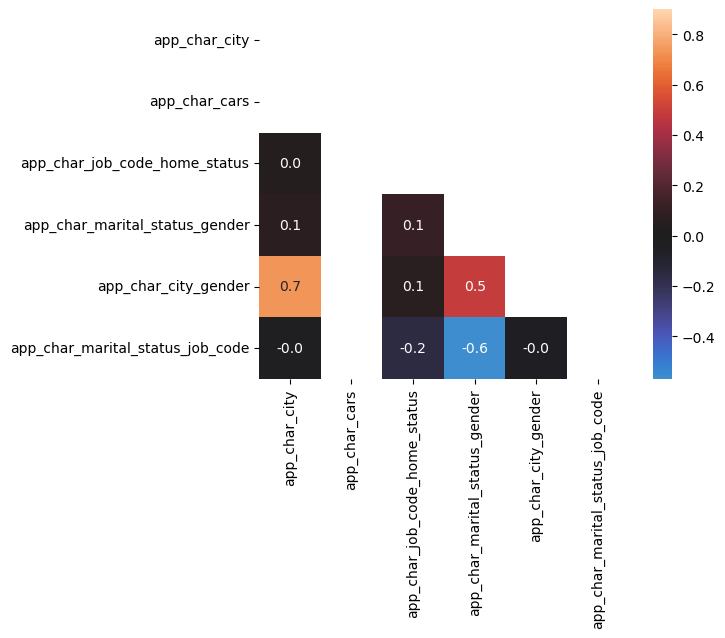

In [37]:
#plt.subplots(figsize=(20, 10))
#corr_df=df.corr()
#heatmap_df = corr_df.drop(varsn).drop(varsn,axis=1)
# Generate a mask for the upper triangle
corr = train_grp[varsc].dropna()
corr = corr.corr()
mask = np.zeros_like(corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, vmax=.9, square=True, annot=True, fmt='.1f', center=0)
#sns.heatmap(df.corr(), vmax=.9, square=True, annot=True, fmt='.1f', center=0)
plt.show()
#check

In [38]:
# #Calculating Gini values for features
#zmiana
# #feature='app_const'
# Gini_vars=pd.DataFrame()
# #from sklearn import metrics
# for feature in vars:
#     sss=pd.DataFrame([feature], columns=[variable_name])
#     fpr, tpr, thresholds = metrics.roc_curve(logit_train[target_name], logit_train[feature])
#     gini=np.absolute(2*metrics.auc(fpr, tpr)-1)
#     sss[gini_train]=gini
#     fpr, tpr, thresholds = metrics.roc_curve(logit_test[target_name], logit_test[feature])
#     gini=np.absolute(2*metrics.auc(fpr, tpr)-1)
#     sss[gini_test]=gini
#     #zmiana przez The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead
#     #Gini_vars=Gini_vars.append(sss,ignore_index=True, sort=False)
#     Gini_vars = pd.concat([Gini_vars, sss], ignore_index=True)
    
# Gini_vars[delta_gini]=np.absolute(Gini_vars[gini_train]-Gini_vars[gini_test])/Gini_vars[gini_train]
# Gini_vars[delta_gini]=Gini_vars[delta_gini].fillna(0)
# Gini_vars=Gini_vars.sort_values(by=[gini_train],ascending=False)
# Gini_vars=Gini_vars.reset_index(drop=True)


In [39]:
def calculate_gini_train_test_r(logit_train=logit_train, logit_test=logit_test, target_name=target_name, vars=vars):
    Gini_vars = pd.DataFrame()
    for feature in vars:
        sss = pd.DataFrame([feature], columns=[variable_name])
        fpr, tpr, thresholds = metrics.roc_curve(logit_train[target_name], logit_train[feature])
        gini = np.absolute(2*metrics.auc(fpr, tpr)-1)
        sss[gini_train] = gini
        fpr, tpr, thresholds = metrics.roc_curve(logit_test[target_name], logit_test[feature])
        gini = np.absolute(2*metrics.auc(fpr, tpr)-1)
        sss[gini_test] = gini
        Gini_vars = pd.concat([Gini_vars, sss], ignore_index=True)

    Gini_vars[delta_gini] = np.absolute(Gini_vars[gini_train]-Gini_vars[gini_test])/Gini_vars[gini_train]
    Gini_vars[delta_gini] = Gini_vars[delta_gini].fillna(0)
    Gini_vars = Gini_vars.sort_values(by=[gini_train],ascending=False)
    Gini_vars = Gini_vars.reset_index(drop=True)
    return Gini_vars

In [40]:
Gini_vars = calculate_gini_train_test_r()
Gini_vars.head(2)

,Variable,Gini train,Gini test,R. Gini
0,act_ccss_dueutl,0.584049,0.570225,0.023669
1,act_ccss_maxdue,0.563235,0.565214,0.003513


In [41]:
#zmiana
# sss=pd.DataFrame(Big_scorecard.groupby(variable_name).agg({INV:['sum'],PSI:['sum'],PSI_tar:['sum']}))
# sss.columns=[INV,PSI,PSI_tar]
# sss=sss.reset_index()

In [42]:
def gini_compute_aggregate_values(Big_scorecard = Big_scorecard, vars = vars):
    sss=pd.DataFrame(Big_scorecard.groupby(variable_name).agg({INV:['sum'],PSI:['sum'],PSI_tar:['sum']}))
    sss.columns=[INV,PSI,PSI_tar]
    sss=sss.reset_index()
    return sss

In [43]:
sss = gini_compute_aggregate_values()
sss.head(3)

,Variable,Infomration Value,Population Stability Index,Population Stability Index for bads
0,act12_n_arrears,0.929041,0.001389,0.001550
1,act12_n_arrears_days,0.569797,0.002205,0.002976
2,act12_n_good_days,0.886390,0.001390,0.001719


In [44]:
#zmiana
# pm = train[vars].isnull().sum() / len(train)
# stat = pd.DataFrame({'percent_missing': pm}).reset_index()
# stat.columns=[variable_name,percent_missing]
# stat[count_unique]=0
# for i in range(stat.shape[0]):
#     #zmiana See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
#     #stat[count_unique][i]=len(pd.unique(train[stat[variable_name][i]]))
#     stat.loc[i, count_unique] = train[stat.loc[i, variable_name]].nunique()

In [45]:
def gini_compute_missing_values(train=train, vars=vars):
    pm = train[vars].isnull().sum() / len(train)
    stat = pd.DataFrame({'percent_missing': pm}).reset_index()
    stat.columns=[variable_name,percent_missing]
    stat[count_unique]=0
    for i in range(stat.shape[0]):
        stat.loc[i, count_unique] = train[stat.loc[i, variable_name]].nunique()
    return stat

In [46]:
stat = gini_compute_missing_values()

In [47]:
Gini_vars=pd.merge(Gini_vars, sss, on=variable_name)
Gini_vars=pd.merge(Gini_vars, stat, on=variable_name)

fin=pd.DataFrame()
# feature='ags6_Iqr_Cncr'
# feature='app_char_job_code'
for feature in vars:
    row=pd.DataFrame(np.array([[1,2,3,4]]),columns=[variable_name,mode_name,mode_pname,type_name])
    row[variable_name]=feature

    ttt=train[[feature]].copy()
    ttt=ttt[ttt[feature].isnull()==False]
    pm2=ttt[feature].mode()
    row[mode_name]=pm2[0]

    ttt2=pd.DataFrame(ttt.groupby(feature)[feature].count()/ttt.shape[0])
    ttt2.columns=['count']
    ttt2=ttt2.reset_index()
    ttt2.columns=['var','count']
    ttt2=ttt2[ttt2['var']==pm2[0]]
    ttt2=ttt2.reset_index()
    row[mode_pname]=ttt2['count'][0]
    row[type_name]='INT'
    for f2 in varsc: 
        if f2==feature: row[type_name]='NOM'
            
    #zmiana
    #fin=fin.append(row, ignore_index=True, sort=False)
    fin = pd.concat([fin, row], ignore_index=True)

Gini_vars=pd.merge(Gini_vars, fin, on=variable_name)

Gini_vars.to_excel('Gini_vars.xlsx', index=False) 
Gini_vars.head()

,Variable,Gini train,Gini test,R. Gini,Infomration Value,Population Stability Index,Population Stability Index for bads,Missing percent,Number of distinct,Mode,P. mode,Type
0,act_ccss_dueutl,0.584049,0.570225,0.023669,1.372238,0.003425,0.003212,0.097273,74,0.0,0.206634,INT
1,act_ccss_maxdue,0.563235,0.565214,0.003513,1.215177,0.004049,0.004297,0.097273,8,0.0,0.206634,INT
2,act_ccss_utl,0.556254,0.551673,0.008237,1.379550,0.001750,0.002122,0.097273,145,0.541667,0.066026,INT
3,act_ccss_n_loans_act,0.543863,0.532196,0.021451,1.279120,0.002506,0.003205,0.097273,7,3.0,0.261462,INT
4,act6_n_arrears,0.520633,0.527211,0.012634,1.116499,0.001166,0.001384,0.077723,7,6.0,0.596836,INT


In [48]:
#Calculating Gini values for features


In [49]:
print(Gini_vars[gini_train].describe())

count    56.000000
mean      0.249515
std       0.178597
min       0.000000
25%       0.085897
50%       0.220301
75%       0.394765
max       0.584049
Name: Gini train, dtype: float64


In [50]:
print(Gini_vars[delta_gini].describe())


count    56.000000
mean      0.159465
std       0.348039
min       0.000000
25%       0.020818
50%       0.089555
75%       0.167534
max       2.534495
Name: R. Gini, dtype: float64


In [51]:
print(Gini_vars[PSI_tar].describe())


count    56.000000
mean      0.004025
std       0.010261
min       0.000077
25%       0.001179
50%       0.001801
75%       0.002823
max       0.058519
Name: Population Stability Index for bads, dtype: float64


In [52]:
print(Gini_vars[PSI].describe())

count    56.000000
mean      0.004183
std       0.010606
min       0.000127
25%       0.001081
50%       0.001541
75%       0.002243
max       0.057467
Name: Population Stability Index, dtype: float64


In [53]:
Gini_vars[PSI].quantile(.25)

0.001080574517702874

In [54]:
#zmiana
#description_results += " Gini_vars=default "
#description_results += "Gini_vars[gini_train]>0.06, Gini_vars[delta_gini]<0.3; "
#todo
sub=Gini_vars[
    (Gini_vars[gini_train]>0.06) #0.05
    & (Gini_vars[delta_gini]<0.3) #<0.2
    & (Gini_vars[PSI_tar]<0.1)
    & (Gini_vars[PSI]<0.1)
].copy()
# sub=Gini_vars[
#     (Gini_vars[gini_train]>Gini_vars[gini_train].quantile(.25)) 
#     & (Gini_vars[delta_gini]<Gini_vars[delta_gini].quantile(.25)) #<0.2
#     & (Gini_vars[PSI_tar]<0.1)
#     & (Gini_vars[PSI]<0.1)
# ].copy()

vars_selected=list(sub[variable_name])
# vars_selected.remove('act_state_7_CMax_Due')
# vars_selected.remove('ags6_Iqr_Cncr')
# vars_selected.remove('ags9_Min_CMin_Days')



print(len(list(vars_selected)))
vars_selected

46


['act_ccss_dueutl',
 'act_ccss_maxdue',
 'act_ccss_utl',
 'act_ccss_n_loans_act',
 'act6_n_arrears',
 'act3_n_arrears',
 'act_ccss_n_loan',
 'act_ccss_min_pninst',
 'act_ccss_min_lninst',
 'act9_n_arrears',
 'act_call_n_loan',
 'act12_n_good_days',
 'act12_n_arrears',
 'act9_n_good_days',
 'act6_n_good_days',
 'act_ccss_n_statC',
 'act3_n_good_days',
 'act12_n_arrears_days',
 'act9_n_arrears_days',
 'act6_n_arrears_days',
 'act_ccss_cc',
 'act3_n_arrears_days',
 'act_cins_min_seniority',
 'act_call_cc',
 'app_loan_amount',
 'app_installment',
 'act_ccss_n_loans_hist',
 'act_cc',
 'act_cus_active',
 'app_number_of_children',
 'act_ccss_min_seniority',
 'act_loaninc',
 'act_cins_n_loan',
 'app_n_installments',
 'app_income',
 'act_ccss_seniority',
 'app_spendings',
 'app_char_marital_status_gender',
 'act_cins_seniority',
 'act_cins_cc',
 'app_char_marital_status_job_code',
 'act_cins_min_pninst',
 'act_cins_utl',
 'act_cins_dueutl',
 'act_cins_min_lninst',
 'act_cins_maxdue']

In [55]:
#Creating full data
#zmiana
#grp_all=grp_train.append(grp_test, ignore_index=True, sort=False)
grp_all = pd.concat([grp_train, grp_test], ignore_index=True, sort=False)
print(grp_all.shape, train.shape, test.shape)

#grp_all.head()

(14981, 62) (10486, 62) (4495, 62)


In [56]:
print(grp_all.columns)

Index(['act_age', 'act_cc', 'act_loaninc', 'app_income', 'app_loan_amount',
       'app_n_installments', 'app_number_of_children', 'app_spendings',
       'app_installment', 'app_char_city', 'app_char_cars', 'act_call_cc',
       'act_cins_n_loan', 'act_ccss_n_loan', 'act_call_n_loan',
       'act_cins_seniority', 'act_cins_min_seniority', 'act_cins_n_loans_hist',
       'act_cins_n_statC', 'act_cins_n_statB', 'act_cins_n_loans_act',
       'act_cins_maxdue', 'act_cins_min_pninst', 'act_cins_min_lninst',
       'act_cins_utl', 'act_cins_dueutl', 'act_cins_cc', 'act_ccss_seniority',
       'act_ccss_min_seniority', 'act_ccss_n_loans_hist', 'act_ccss_n_statC',
       'act_ccss_n_statB', 'act_ccss_n_loans_act', 'act_ccss_maxdue',
       'act_ccss_min_pninst', 'act_ccss_min_lninst', 'act_ccss_utl',
       'act_ccss_dueutl', 'act_ccss_cc', 'act_cus_active', 'act3_n_arrears',
       'act3_n_arrears_days', 'act3_n_good_days', 'act6_n_arrears',
       'act6_n_arrears_days', 'act6_n_good_days',

In [57]:
#Creating time variable
#zmiana -  PerformanceWarning: DataFrame is highly fragmented.  
#grp_all[time_report_name]=grp_all[time_name].astype(str).str[0:4]
grp_all = grp_all.copy()
grp_all[time_report_name] = grp_all[time_name].astype(str).str[0:4]
grp_all[[time_name, time_report_name]].head()

,period,Time
0,197805,1978
1,198506,1985
2,198209,1982
3,198105,1981
4,198604,1986


In [58]:
#import xlsxwriter

In [59]:
#Variable_report
startrow=2

# Dump Pandas DataFrame to Excel sheet
writer = pd.ExcelWriter('Variable_report.xlsx', engine='xlsxwriter')
Gini_vars.to_excel(writer, sheet_name=variable_name, startrow=1, index_label=None, index=False)

series = Gini_vars[variable_name]
max_len = max((series.astype(str).map(len).max(),len(str(series.name)))) + 1 

book = writer.book
sheet = writer.sheets[variable_name]
#format1 = workbook.add_format({'num_format': '#,##0.00'})
format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('B:B', None, format1)
sheet.set_column('C:C', None, format1)
sheet.set_column('D:D', None, format1)
sheet.set_column(0,0, max_len)
sheet.set_column(1,1,len(gini_train))
sheet.set_column(2,2,len(gini_test))
sheet.set_column(3,3,len(delta_gini))
sheet.set_column(4,4,len(INV))
sheet.set_column(5,5,len(PSI))
sheet.set_column(6,6,len(PSI_tar))
sheet.set_column(7,7,len(percent_missing))
sheet.set_column(8,8,len(count_unique))

sss2=pd.DataFrame(grp_all[time_report_name].value_counts())
ntimes=sss2.shape[0]
    
    
for feature in vars_selected: 
    sssgr=pd.DataFrame(grp_all.groupby([time_report_name]).agg({target_name:['count']}))
    sssgr=pd.DataFrame(sssgr[target_name])
    sssgr=sssgr.reset_index()
    fin=pd.DataFrame()
    sss=pd.DataFrame()
    ddd=pd.DataFrame()
    sss=pd.DataFrame(grp_all.groupby([feature,time_report_name]).agg({target_name:['sum','count']}))
    sss=pd.DataFrame(sss[target_name])
    sss=sss.reset_index()
    sss=sss.rename(columns={"sum": event_name, "count": all_name, feature:grp_name})
    sss=pd.merge(sss, sssgr, on=time_report_name)
    sss[nonevent_name]=sss[all_name]-sss[event_name]
    sss[event_rate_name]=sss[event_name]/sss[all_name]
    sss[share_name]=sss[all_name]/sss["count"]
    sss=sss[[grp_name,time_report_name,event_name,all_name,nonevent_name,event_rate_name,share_name]]
    sss=sss.sort_values(by=[grp_name,time_report_name])
    
    sub=Big_scorecard[Big_scorecard[variable_name]==feature]
    sub=sub[[grp_name,condition_name,event_rate_name,share_name,all_name,event_name,nonevent_name]]
    ncat=sub.shape[0]
    
    shname=feature[0:31]
    sub.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False)
    sss.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False, startcol=8)
    book = writer.book
    sheet = writer.sheets[shname]
    bold = book.add_format({'bold': True, 'size': 24})
    sheet.write('A1', variable_name+': '+feature, bold)
    bold = book.add_format({'bold': True, 'size': 12})
    boldp = book.add_format({'bold': True, 'size': 12, 'num_format': '0.0%'})
    sheet.write_formula('D'+str(startrow+ncat+2), '=SUM(D4:D'+str(startrow+ncat+1)+')', boldp)
    sheet.write_formula('E'+str(startrow+ncat+2), '=SUM(E4:E'+str(startrow+ncat+1)+')', bold)
    sheet.write_formula('F'+str(startrow+ncat+2), '=SUM(F4:F'+str(startrow+ncat+1)+')', bold)
    sheet.write_formula('G'+str(startrow+ncat+2), '=SUM(G4:G'+str(startrow+ncat+1)+')', bold)

    #format1 = workbook.add_format({'num_format': '#,##0.00'})
    format1 = book.add_format({'num_format': '0.0%'})
    sheet.set_column('C:C', None, format1)
    sheet.set_column('D:D', None, format1)
    sheet.set_column('N:N', None, format1)
    sheet.set_column('O:O', None, format1)

    series = sub[condition_name]
    max_len = max((series.astype(str).map(len).max(),len(str(series.name)))) + 1
    sheet.set_column(1,1,max_len)

    # Chart
    chart = book.add_chart({'type': 'line'})
    chart.set_title({'name': event_rate_name})
    chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
    for i in range(ncat):
        chart.add_series({'values': '='+shname+'!N'+str(4+i*ntimes)+':N'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                         'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
    chart.set_legend({'position': 'bottom'})
    sheet.insert_chart('A'+str(ncat+6), chart)


    chart = book.add_chart({'type': 'line'})
    chart.set_title({'name': share_name})
    chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
    for i in range(ncat):
        chart.add_series({'values': '='+shname+'!O'+str(4+i*ntimes)+':O'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                         'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
    chart.set_legend({'position': 'bottom'})
    sheet.insert_chart('A'+str(ncat+6+18), chart)
#zmiana
#writer.save()
#writer.close()

In [60]:
#!pip3 install statsmodels check

In [61]:
#Simple RFE selection method
#description_results += " LogisticRegression:solver='lbfgs -"
#model = LogisticRegression(solver='lbfgs', multi_class='auto',max_iter=1000) #zamiana
model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000) #zmiana
rfe = RFE(estimator=model, n_features_to_select=1, step=1)
rfe.fit(logit_train[vars_selected], logit_train[target_name])


RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=1)

In [62]:
def assess(selected_vars):
    Model_list0=pd.DataFrame(np.array([['b',2,'b',1.99,1.99,1.99,1.99,1.99,1.99]]),
        columns=['Variables','nnegative_betas','max_pvalue','gini_train','gini_test',
                 'delta_gini','max_vif','max_con_index','max_pearson',])

    var_list=''
    for i,v in enumerate(selected_vars):
        if i==0:
            var_list=v
        else:
            var_list=var_list+','+v

    Model_list0['Variables'][0]=var_list

    features = selected_vars+[intercept_name]
    X=logit_train[features]
    y=logit_train[target_name]
    X_test=logit_test[features]
    y_test=logit_test[target_name]

    model = sm.Logit(y, X).fit(disp = 0, method='newton')

    pv=0
    nnegative_betas=0
    for i in range(len(list(model.params))):
        if model.params[i]<0 and model.params.index[i]!=intercept_name: 
            nnegative_betas+=1
        if model.params.index[i]!=intercept_name: 
            pv=max(pv,model.pvalues[i])
    max_pvalue=pv

    pre = model.predict(X)
    fpr, tpr, thresholds = roc_curve(y, pre)
    gini_train = np.absolute(2 * auc(fpr, tpr) - 1)

    pre = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, pre)
    gini_test = np.absolute(2 * auc(fpr, tpr) - 1)

    delta_gini=np.absolute(gini_train-gini_test)/gini_train
    if math.isnan(delta_gini): delta_gini=0

    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif=1
    for i in range(X.shape[1]):
        if list(X)[i]!=intercept_name:
            vif = max(float(variance_inflation_factor(np.asarray(X), i)),vif)
    max_vif=vif

    X_new = X/(((X*X).sum())**0.5)
    Xt = np.transpose(X_new)
    XtX = np.dot(Xt,X_new)
    Eig = np.linalg.eig(XtX)[0]
    max_con_index = np.sqrt(np.max(Eig) / np.min(Eig))

    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    upper = upper.fillna(0)
    max_pearson=max(upper.max())

    Model_list0['nnegative_betas'][0]=int(nnegative_betas)
    Model_list0['max_pvalue'][0]=float(max_pvalue)
    Model_list0['gini_train'][0]=float(gini_train)
    Model_list0['gini_test'][0]=float(gini_test)
    Model_list0['delta_gini'][0]=float(delta_gini)
    Model_list0['max_vif'][0]=float(max_vif)
    Model_list0['max_con_index'][0]=float(max_con_index)
    Model_list0['max_pearson'][0]=float(max_pearson)

    return Model_list0

In [63]:
resultr = list(rfe.ranking_ <= 30)
a = [vars_selected[i] for i, val in enumerate(resultr) if val == 1]
print(a)

['act_ccss_dueutl', 'act_ccss_maxdue', 'act_ccss_utl', 'act6_n_arrears', 'act_ccss_min_lninst', 'act9_n_arrears', 'act12_n_good_days', 'act_ccss_n_statC', 'act9_n_arrears_days', 'act_ccss_cc', 'act3_n_arrears_days', 'act_cins_min_seniority', 'act_call_cc', 'app_loan_amount', 'app_installment', 'act_ccss_n_loans_hist', 'act_cc', 'act_cus_active', 'app_number_of_children', 'act_ccss_min_seniority', 'act_cins_n_loan', 'app_n_installments', 'app_income', 'app_spendings', 'app_char_marital_status_gender', 'act_cins_seniority', 'act_cins_cc', 'app_char_marital_status_job_code', 'act_cins_min_pninst', 'act_cins_dueutl']


In [64]:
#Assessment of combinations of feature1
#description_results += "number_vars=12 number_features=10; "

number_vars=12
number_features=10

resultr = list(rfe.ranking_ <= number_vars)
selected_features = [vars_selected[i] for i, val in enumerate(resultr) if val == 1]

In [65]:
selected_features

['act_ccss_dueutl',
 'act_ccss_n_statC',
 'act_call_cc',
 'app_loan_amount',
 'act_cc',
 'app_number_of_children',
 'act_cins_n_loan',
 'app_income',
 'app_spendings',
 'act_cins_seniority',
 'app_char_marital_status_job_code',
 'act_cins_dueutl']

In [66]:
assess(selected_features)

,Variables,nnegative_betas,max_pvalue,gini_train,gini_test,delta_gini,max_vif,max_con_index,max_pearson
0,"act_ccss_dueutl,act_ccss_n_statC,act_call_cc,a...",0,0.000012,0.769494,0.752154,0.022534,2.053552,33.479741,0.591112


In [67]:
Model_list=pd.DataFrame()

#Model_list=Model_list.append(assess(selected_features), ignore_index=True, sort=False)
#zmiana
Model_list = pd.concat([Model_list, assess(selected_features)], ignore_index=True, sort=False)

In [68]:
index = 2**number_vars-1
for i in range(index):
    get_bin = lambda i, n: format(i, 'b').zfill(n)
    bin=get_bin(i,number_vars)
    suma=0
    selected_v=list([])
    for i,p in enumerate(bin):
        if p=='1': 
            suma=suma+1
            selected_v.append(selected_features[i])
    if suma==number_features:
#         print(selected_v)
        #Model_list=Model_list.append(assess(selected_v), ignore_index=True, sort=False)
        #zmiana
        Model_list = pd.concat([Model_list, assess(selected_v)], ignore_index=True, sort=False)
        

Model_list.head()

,Variables,nnegative_betas,max_pvalue,gini_train,gini_test,delta_gini,max_vif,max_con_index,max_pearson
0,"act_ccss_dueutl,act_ccss_n_statC,act_call_cc,a...",0,0.000012,0.769494,0.752154,0.022534,2.053552,33.479741,0.591112
1,"act_call_cc,app_loan_amount,act_cc,app_number_...",0,0.000001,0.589856,0.575819,0.023798,1.953897,31.146382,0.591112
2,"act_ccss_n_statC,app_loan_amount,act_cc,app_nu...",0,0.000033,0.692185,0.682264,0.014333,1.589607,31.046538,0.529419
3,"act_ccss_n_statC,act_call_cc,act_cc,app_number...",2,0.667889,0.661544,0.647753,0.020847,1.844535,31.235747,0.591112
4,"act_ccss_n_statC,act_call_cc,app_loan_amount,a...",0,0.004561,0.700183,0.692804,0.010538,1.650712,30.941469,0.529419


In [69]:
#Model_list = pd.concat([Model_list, assess(selected_v)], ignore_index=True, sort=False)
# description_results += "number_vars=30 number_features=7"

# number_vars=30
# number_features=7

In [70]:
Model_list.shape

(67, 9)

In [71]:
Model_list.head()

,Variables,nnegative_betas,max_pvalue,gini_train,gini_test,delta_gini,max_vif,max_con_index,max_pearson
0,"act_ccss_dueutl,act_ccss_n_statC,act_call_cc,a...",0,0.000012,0.769494,0.752154,0.022534,2.053552,33.479741,0.591112
1,"act_call_cc,app_loan_amount,act_cc,app_number_...",0,0.000001,0.589856,0.575819,0.023798,1.953897,31.146382,0.591112
2,"act_ccss_n_statC,app_loan_amount,act_cc,app_nu...",0,0.000033,0.692185,0.682264,0.014333,1.589607,31.046538,0.529419
3,"act_ccss_n_statC,act_call_cc,act_cc,app_number...",2,0.667889,0.661544,0.647753,0.020847,1.844535,31.235747,0.591112
4,"act_ccss_n_statC,act_call_cc,app_loan_amount,a...",0,0.004561,0.700183,0.692804,0.010538,1.650712,30.941469,0.529419


In [72]:
#description_results += " Model_list['max_pvalue']<=0.01 "
subModel_list=Model_list[
    (Model_list['nnegative_betas']==0) 
    & (Model_list['max_pvalue']<=0.01) #0.01
    & (Model_list['max_vif']<=3.0) 
].copy()

subModel_list=subModel_list.sort_values(by=['gini_test'],ascending=False)
subModel_list=subModel_list.reset_index()
subModel_list.head()

,index,Variables,nnegative_betas,max_pvalue,gini_train,gini_test,delta_gini,max_vif,max_con_index,max_pearson
0,0,"act_ccss_dueutl,act_ccss_n_statC,act_call_cc,a...",0,0.000012,0.769494,0.752154,0.022534,2.053552,33.479741,0.591112
1,42,"act_ccss_dueutl,act_ccss_n_statC,act_call_cc,a...",0,0.000016,0.766291,0.750372,0.020775,1.869708,29.415481,0.529419
2,41,"act_ccss_dueutl,act_ccss_n_statC,act_call_cc,a...",0,0.000046,0.764838,0.749876,0.019562,1.85338,30.583406,0.529419
3,43,"act_ccss_dueutl,act_ccss_n_statC,act_call_cc,a...",0,0.00001,0.765322,0.749876,0.020183,1.869714,28.137768,0.529419
4,40,"act_ccss_dueutl,act_ccss_n_statC,act_call_cc,a...",0,0.001356,0.766303,0.749654,0.021727,1.65985,28.155666,0.498646


In [73]:
subModel_list['Variables'][0].split(',')

['act_ccss_dueutl',
 'act_ccss_n_statC',
 'act_call_cc',
 'app_loan_amount',
 'act_cc',
 'app_number_of_children',
 'act_cins_n_loan',
 'app_income',
 'app_spendings',
 'act_cins_seniority',
 'app_char_marital_status_job_code',
 'act_cins_dueutl']

In [74]:
#Model assessment based on selected variables selected_features

selected_features=subModel_list['Variables'][0].split(',')

features = selected_features+[intercept_name]
X=logit_train[features]
y=logit_train[target_name]
X_test=logit_test[features]
y_test=logit_test[target_name]

result = {'Efects': pd.DataFrame(),
          gini_train: np.nan,
          gini_test: np.nan,
          delta_gini: np.nan,
          max_pvalue: '',
          nnegative_betas: 0,
          max_vif: np.nan,
          max_pearson: np.nan,
          max_con_index: np.nan,
          'KS score': np.nan,
          'PSI score': np.nan,
          'Gains1': np.nan,
          'Gains2': np.nan,
          'Gains3': np.nan,
          'Gains4': np.nan,
          'Gains5': np.nan,
          'Gains10': np.nan,
          'Gains50': np.nan,
          'Lift1': np.nan,
          'Lift2': np.nan,
          'Lift3': np.nan,
          'Lift4': np.nan,
          'Lift5': np.nan,
          'Lift10': np.nan,
          'Lift50': np.nan
          }
#zmiana
#description_results += " Logit method='lbfgs;"
#model = sm.Logit(y, X).fit(disp = 0,method='newton') 
model = sm.Logit(y, X).fit(disp = 0, method='lbfgs') 

#result['Coef']=model.params
#result['P_value']=model.pvalues
ggg=model.wald_test_terms().summary_frame().reset_index()
ggg.columns=[variable_name,wald_test,pvalue,degree_free]
ppp=pd.DataFrame(model.params,columns=[estimation]).reset_index()
ppp.columns=[variable_name,estimation]
ppp=pd.merge(ppp, ggg, on=variable_name)
se=model.summary2().tables[1].reset_index()
se.columns=[variable_name,'c',std_err,'z','p','l','r']
se=se[[variable_name,std_err]]
ppp=pd.merge(ppp, se, on=variable_name)
ppp=ppp[[variable_name,degree_free,estimation,std_err,wald_test,pvalue]]

def pval(x):
    if x>0.0001: wyn='%.4f' % x
    else: wyn='<.0001'
    return wyn

ppp[pvalue]=ppp[pvalue].apply(pval)

result['Efects']=ppp

pv=0
for i in range(len(list(model.params))):
    if model.params[i]<0 and model.params.index[i]!=intercept_name: 
        result[nnegative_betas]+=1
    if model.params.index[i]!=intercept_name: 
        pv=max(pv,model.pvalues[i])
#result[max_pvalue]=float(round(pv, 6))
result[max_pvalue]=pval(pv)

pre = model.predict(X)
fpr, tpr, thresholds = roc_curve(y, pre)
result[gini_train] = float(np.absolute(2 * auc(fpr, tpr) - 1))

pre = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pre)
result[gini_test] = float(np.absolute(2 * auc(fpr, tpr) - 1))

result[delta_gini]=np.absolute(result[gini_train]-result[gini_test])/result[gini_train]
if math.isnan(result[delta_gini]): result[delta_gini]=0.0

#from statsmodels.stats.outliers_influence import variance_inflation_factor
vif=1
for i in range(X.shape[1]):
    if list(X)[i]!=intercept_name:
        vif = max(float(variance_inflation_factor(np.asarray(X), i)),vif)
result[max_vif]=float(vif)

X_new = X/(((X*X).sum())**0.5)
Xt = np.transpose(X_new)
XtX = np.dot(Xt,X_new)
Eig = np.linalg.eig(XtX)[0]
result[max_con_index] = float(np.sqrt(np.max(Eig) / np.min(Eig)))

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper = upper.fillna(0)
result[max_pearson]=float(max(upper.max()))

result

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


{'Efects':                             Variable  Degrees of freedom  Estimation  \
 0                    act_ccss_dueutl                   1    0.847602   
 1                   act_ccss_n_statC                   1    0.913471   
 2                        act_call_cc                   1    0.487268   
 3                    app_loan_amount                   1    0.612563   
 4                             act_cc                   1    0.467517   
 5             app_number_of_children                   1    1.139874   
 6                    act_cins_n_loan                   1    0.438197   
 7                         app_income                   1    0.486039   
 8                      app_spendings                   1    0.644882   
 9                 act_cins_seniority                   1    0.673798   
 10  app_char_marital_status_job_code                   1    1.567102   
 11                   act_cins_dueutl                   1    0.641188   
 12                         Intercept    

In [75]:
selected_features

['act_ccss_dueutl',
 'act_ccss_n_statC',
 'act_call_cc',
 'app_loan_amount',
 'act_cc',
 'app_number_of_children',
 'act_cins_n_loan',
 'app_income',
 'app_spendings',
 'act_cins_seniority',
 'app_char_marital_status_job_code',
 'act_cins_dueutl']

In [76]:
#Creating Scorecard
features=list(result['Efects'][variable_name].copy())
features.remove(intercept_name)
Scorecard=Big_scorecard[Big_scorecard[variable_name].isin(features)].copy()
coef=result['Efects']
coef=coef[[variable_name,estimation]]
coef.columns=[variable_name,beta_name]
alpha=float(coef[coef[variable_name]==intercept_name][beta_name])
Scorecard=pd.merge(Scorecard, coef, on=variable_name)
factor = 20/np.log(2)
v = len(features)
alpp=Scorecard[logit_name]*Scorecard[beta_name]*factor
#zmiana
#alp=-alpp.sum()+300
alp=alpp.sum()+300
alpp2=Scorecard.copy()
alpp2=alpp2[alpp2[grp_name]==0]
alpp2[fbeta_name]=alpp2[logit_name]*alpp2[beta_name]
alpp2=alpp2[[variable_name,fbeta_name]]
Scorecard=pd.merge(Scorecard, alpp2, on=variable_name)
Scorecard[score_name]=-(Scorecard[logit_name]*Scorecard[beta_name]-Scorecard[fbeta_name] + alpha/v)*factor+alp/v
Scorecard[score_name]=round(Scorecard[score_name])
#Scorecard.to_excel('Scorecard.xlsx', index=False) 
Scorecard.head()

,Variable,Condition,BR,Share,All,Bad,Good,Logit,GRP,Type,Bad share,Good share,Infomration Value,Share test,Bad share test,Population Stability Index,Population Stability Index for bads,Beta,FBeta,Score
0,act_cc,0.744 <= act_cc,0.836864,0.180050,1888,1580.0,308.0,1.635080,0,INT,0.209161,0.105048,0.071652,0.181980,0.206462,0.000021,0.000035,0.467517,0.764427,117.0
1,act_cc,0.516 <= act_cc < 0.744,0.752309,0.454320,4764,3584.0,1180.0,1.110965,1,INT,0.474451,0.402456,0.011846,0.467853,0.483692,0.000397,0.000178,0.467517,0.764427,124.0
2,act_cc,act_cc < 0.347,0.664510,0.103185,1082,719.0,363.0,0.683458,2,INT,0.095181,0.123806,0.007520,0.098331,0.092615,0.000234,0.000070,0.467517,0.764427,130.0
3,act_cc,0.421 <= act_cc < 0.516,0.637479,0.170990,1793,1143.0,650.0,0.564439,3,INT,0.151311,0.221692,0.026868,0.159956,0.142154,0.000736,0.000571,0.467517,0.764427,131.0
4,act_cc,0.347 <= act_cc < 0.421,0.550574,0.091455,959,528.0,431.0,0.202988,4,INT,0.069897,0.146999,0.057260,0.091880,0.075077,0.000002,0.000370,0.467517,0.764427,136.0


In [77]:
#Creating full scored data
#scored_all=grp_train.append(grp_test, ignore_index=True, sort=False)
scored_all=grp_all.copy()
features=list(result['Efects'][variable_name].copy())
features.remove(intercept_name)
scored_all=scored_all[features+[target_name]+[time_name]+[time_report_name]+[event_value]+[all_value]+[id_row]]

for feature in features:
    scored_all=scored_all.rename(columns={feature: grp_name})
    sc=Scorecard[Scorecard[variable_name]==feature].copy()
    sc=sc[[grp_name,score_name]]
    scored_all=pd.merge(scored_all, sc, on=grp_name)
    scored_all=scored_all.rename(columns={score_name: feature})
    #zmiana - FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
    #scored_all=scored_all.drop(grp_name,1)
    scored_all = scored_all.drop(grp_name, axis=1)
scored_all[score_name]=0
for feature in features:
    scored_all[score_name]=scored_all[score_name]+scored_all[feature]
#scored_all.to_excel('Scored_all.xlsx', index=False) 
#scored_all.shape
scored_all.head()

,default_cross12,period,Time,outstanding_bad,outstanding,aid,act_ccss_dueutl,act_ccss_n_statC,act_call_cc,app_loan_amount,act_cc,app_number_of_children,act_cins_n_loan,app_income,app_spendings,act_cins_seniority,app_char_marital_status_job_code,act_cins_dueutl,Score
0,1.0,197805,1978,5000.0,5000.0,css1978051100147,142.0,117.0,137.0,117.0,136.0,126.0,117.0,123.0,122.0,117.0,137.0,144.0,1535.0
1,1.0,197801,1978,5000.0,5000.0,css1978010600152,142.0,117.0,137.0,117.0,136.0,126.0,117.0,123.0,122.0,117.0,137.0,144.0,1535.0
2,1.0,197809,1978,5000.0,5000.0,css1978091600133,117.0,117.0,137.0,117.0,136.0,126.0,117.0,123.0,122.0,117.0,137.0,144.0,1510.0
3,1.0,197708,1977,5000.0,5000.0,css1977081800148,117.0,117.0,137.0,117.0,136.0,126.0,117.0,123.0,122.0,117.0,137.0,144.0,1510.0
4,1.0,197808,1978,5000.0,5000.0,css1978081800148,126.0,117.0,130.0,117.0,124.0,126.0,117.0,123.0,122.0,117.0,137.0,144.0,1500.0


In [78]:
#Creating train scored data
scored_train=grp_train.copy()
features=list(result['Efects'][variable_name].copy())
features.remove(intercept_name)
scored_train=scored_train[features+[target_name]+[event_value]+[all_value]+[id_row]]

for feature in features:
    scored_train=scored_train.rename(columns={feature: grp_name})
    sc=Scorecard[Scorecard[variable_name]==feature].copy()
    sc=sc[[grp_name,score_name]]
    scored_train=pd.merge(scored_train, sc, on=grp_name)
    scored_train=scored_train.rename(columns={score_name: feature})
    #zmiana
    #scored_train=scored_train.drop(grp_name,1)
    scored_train = scored_train.drop(grp_name, axis=1)

scored_train[score_name]=0
for feature in features:
    scored_train[score_name]=scored_train[score_name]+scored_train[feature]

scored_train.head(3)
# scored_train.shape

,default_cross12,outstanding_bad,outstanding,aid,act_ccss_dueutl,act_ccss_n_statC,act_call_cc,app_loan_amount,act_cc,app_number_of_children,act_cins_n_loan,app_income,app_spendings,act_cins_seniority,app_char_marital_status_job_code,act_cins_dueutl,Score
0,1.0,5000.0,5000.0,css1978051100147,142.0,117.0,137.0,117.0,136.0,126.0,117.0,123.0,122.0,117.0,137.0,144.0,1535.0
1,1.0,5000.0,5000.0,css1978010600152,142.0,117.0,137.0,117.0,136.0,126.0,117.0,123.0,122.0,117.0,137.0,144.0,1535.0
2,1.0,5000.0,5000.0,css1978091600133,117.0,117.0,137.0,117.0,136.0,126.0,117.0,123.0,122.0,117.0,137.0,144.0,1510.0


In [79]:
#Creating test scored data
scored_test=grp_test.copy()
features=list(result['Efects'][variable_name].copy())
features.remove(intercept_name)
scored_test=scored_test[features+[target_name]+[event_value]+[all_value]+[id_row]]

for feature in features:
    scored_test=scored_test.rename(columns={feature: grp_name})
    sc=Scorecard[Scorecard[variable_name]==feature].copy()
    sc=sc[[grp_name,score_name]]
    scored_test=pd.merge(scored_test, sc, on=grp_name)
    scored_test=scored_test.rename(columns={score_name: feature})
    #zmiana - FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
    #scored_test=scored_test.drop(grp_name,1)
    scored_test = scored_test.drop(grp_name, axis=1)
scored_test[score_name]=0
for feature in features:
    scored_test[score_name]=scored_test[score_name]+scored_test[feature]

scored_test.head(3)
# scored_test.shape

,default_cross12,outstanding_bad,outstanding,aid,act_ccss_dueutl,act_ccss_n_statC,act_call_cc,app_loan_amount,act_cc,app_number_of_children,act_cins_n_loan,app_income,app_spendings,act_cins_seniority,app_char_marital_status_job_code,act_cins_dueutl,Score
0,1.0,5000.0,5000.0,css1987052400085,176.0,117.0,130.0,117.0,131.0,126.0,117.0,132.0,127.0,136.0,117.0,117.0,1543.0
1,1.0,5000.0,5000.0,css1986012300042,117.0,117.0,117.0,117.0,124.0,117.0,120.0,125.0,134.0,136.0,117.0,117.0,1458.0
2,1.0,5000.0,5000.0,css1986040400054,132.0,130.0,129.0,117.0,124.0,117.0,127.0,125.0,127.0,136.0,117.0,117.0,1498.0


In [80]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
#     ncat=10
#     data['bucket'] = pd.qcut(data[prob], ncat)
#     grouped = data.groupby('bucket', as_index = False)
    grouped = data.groupby(prob, as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['allq']   = grouped.count()[target]
    ssss=kstable['allq'].sum()
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=True).reset_index(drop = True)
#     kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
#     kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['cum_all']=(kstable.allq / ssss).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 5)

    #Formating
#     kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
#     kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
#     kstable['cum_all']= kstable['cum_all'].apply('{0:.2%}'.format)
#     kstable.index = range(1,ncat+1)
#     kstable.index.rename('Decile', inplace=True)
#     pd.set_option('display.max_columns', 9)
    #print(kstable)
    
    #Display KS
#     from colorama import Fore
#     print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [81]:
#Calculating KS score, PSI Score, Lifts and Gains
data=scored_test.copy()
kst=ks(data=data,target=target_name, prob=score_name)
result['KS score']=float(kst['KS'].max())

lift_list=[1,2,3,4,5,10,50]
for cen in lift_list:
    per=cen/100
    kst1=kst[kst['cum_all']<=per].copy()
    gains=kst1['cum_eventrate'].max()
    result['Gains'+str(cen)]=float(gains)
    result['Lift'+str(cen)]=float(gains/per)
    
datate=scored_test.copy()
datate['dataset']='Test'
datatr=scored_train.copy()
datatr['dataset']='Train'
data_all=datatr.append(datate, ignore_index=True, sort=False)
data_all=data_all[[score_name,'dataset']]
# print(datatr.shape, datate.shape, data_all.shape)
# data_all.head()

data_all['bucket'] = pd.qcut(data_all[score_name], 5)

ssstr=pd.DataFrame(data_all[data_all['dataset']=='Train'].groupby('bucket').count())
ssstr=ssstr.reset_index()
ssstr['tr']=ssstr['dataset']/datatr.shape[0]
ssstr=ssstr[['bucket','tr']]

ssste=pd.DataFrame(data_all[data_all['dataset']=='Test'].groupby('bucket').count())
ssste=ssste.reset_index()
ssste['te']=ssste['dataset']/datate.shape[0]
ssste=ssste[['bucket','te']]

sssall=pd.merge(ssste, ssstr, on=['bucket'], how='outer')
sssall['te']=sssall['te'].fillna(0)
sssall['tr']=sssall['tr'].fillna(0)

sssall[PSI]=(sssall['tr']-sssall['te'])*np.log((sssall['tr']+0.0001) / (sssall['te']+0.0001))

result['PSI score']=float(sssall[PSI].sum())
    
    
result

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_3096/3116650569.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_all=datatr.append(datate, ignore_index=True, sort=False)


{'Efects':                             Variable  Degrees of freedom  Estimation  \
 0                    act_ccss_dueutl                   1    0.847602   
 1                   act_ccss_n_statC                   1    0.913471   
 2                        act_call_cc                   1    0.487268   
 3                    app_loan_amount                   1    0.612563   
 4                             act_cc                   1    0.467517   
 5             app_number_of_children                   1    1.139874   
 6                    act_cins_n_loan                   1    0.438197   
 7                         app_income                   1    0.486039   
 8                      app_spendings                   1    0.644882   
 9                 act_cins_seniority                   1    0.673798   
 10  app_char_marital_status_job_code                   1    1.567102   
 11                   act_cins_dueutl                   1    0.641188   
 12                         Intercept    

In [82]:
#Creating gini_curves_model
sc=scored_all[[score_name,target_name]].copy()
sc['rank'] = sc[score_name].rank()
sc['grouping'] = round(sc['rank']*(20-1)/(len(sc[score_name])+1))
sss=pd.DataFrame(sc.groupby(['grouping']).agg({target_name:['sum','count']}))
sss=pd.DataFrame(sss[target_name])
sss=sss.reset_index()
sss['count']=sss['count']-sss['sum']
sss=sss.rename(columns={'count':'goods', 'sum':'bads'})
sss=sss[['bads','goods']]
# import openpyxl
wb = openpyxl.load_workbook('ASB_PYTHON/gini_curves_template.xlsx')
ws = wb.active
for i in range(sss.shape[0]):
    ws.cell(row=9+i, column=4).value = sss['bads'][i]
    ws.cell(row=9+i, column=5).value = sss['goods'][i]
wb.save('ASB_PYTHON/gini_curves_model.xlsx')

In [83]:
#Gini on scored_all
fpr, tpr, thresholds = metrics.roc_curve(scored_all[target_name], scored_all[score_name])
gini=np.absolute(2*metrics.auc(fpr, tpr)-1)
gini
#0.73

0.7639829971023953

In [84]:
#Gini over time
#scored=scored_all[[target_name, score_name, time_report_name]].copy()
#zmiana
scored=scored_all.loc[:, [target_name, score_name, time_report_name]].copy()
ulist=np.unique(scored[time_report_name])
time_gini=pd.DataFrame(ulist,columns=[time_report_name])
time_gini['Gini']=0.0

for t in range(len(ulist)):
    #scored_sub=scored[scored[time_report_name]==ulist[t]].copy()
    #zmiana
    scored_sub=scored.loc[scored[time_report_name] == ulist[t], :].copy()
    fpr, tpr, thresholds = metrics.roc_curve(scored_sub[target_name], scored_sub[score_name])
    #time_gini['Gini'][t]=np.absolute(2*metrics.auc(fpr, tpr)-1)
    #zmiana
    time_gini.loc[t, 'Gini'] = np.absolute(2*metrics.auc(fpr, tpr)-1)
time_gini

,Time,Gini
0,1975,0.681743
1,1976,0.713741
2,1977,0.727494
3,1978,0.795166
4,1979,0.767098
5,1980,0.791659
6,1981,0.798357
7,1982,0.788649
8,1983,0.793912
9,1984,0.770472


In [85]:
#Calibration
cal_scored=scored_all[[id_row]+[score_name,target_name,time_report_name]].copy()
cal_scored[intercept_name]=1
# import math
# import statsmodels.api as sm
# from statsmodels.discrete.discrete_model import Logit

features=[score_name,intercept_name]
X=cal_scored[features]
y=cal_scored[target_name]
#description_results+="calibratino sm.logit method=newton; "
model_cal=sm.Logit(y,X).fit(disp=0,method='newton')

def kal(x):
    r=1/(1+math.exp(-(model_cal.params[0]*x+model_cal.params[1])))
    if r<0: r=0
    if r>1: r=1
    return r

cal_scored[prob_event]=cal_scored[score_name].apply(kal)
scored_all[prob_event]=scored_all[score_name].apply(kal)
print(model_cal.params)
print(model_cal.params[0],model_cal.params[1])
cal_scored.head()

Score        -0.034318
Intercept    54.736827
dtype: float64
-0.03431815667829001 54.73682700667037


,aid,Score,default_cross12,Time,Intercept,PD
0,css1978051100147,1535.0,1.0,1978,1,0.886799
1,css1978010600152,1535.0,1.0,1978,1,0.886799
2,css1978091600133,1510.0,1.0,1978,1,0.948652
3,css1977081800148,1510.0,1.0,1977,1,0.948652
4,css1978081800148,1500.0,1.0,1978,1,0.963016


In [86]:
#print(cal_scored.mean())

In [87]:
kalt=pd.DataFrame(cal_scored.groupby([time_report_name]).agg({target_name:['count','mean'], prob_event:['mean']}))
kalt=kalt.reset_index()
kalt.columns=[time_report_name,'ALL',event_rate_name,prob_event]
kalt

,Time,ALL,BR,PD
0,1975,1192,0.754195,0.799172
1,1976,1189,0.754415,0.776472
2,1977,1187,0.755687,0.757177
3,1978,1210,0.754545,0.749797
4,1979,1173,0.756181,0.733742
5,1980,1186,0.746206,0.737954
6,1981,1156,0.742215,0.725785
7,1982,1094,0.712980,0.701522
8,1983,1105,0.704072,0.686538
9,1984,1109,0.696123,0.690291


In [88]:
#Additional calibration test

n_groups=10
sc=scored_all.copy()
sc['rank'] = sc[score_name].rank()
sc['grouping'] = round(sc['rank']*(n_groups-1)/(len(sc[score_name])+1))
sss=pd.DataFrame(sc.groupby(['grouping']).agg({
    score_name:['min','max'],
    target_name:['mean'],
    'PD': ['mean']
}))
sss=sss.reset_index()
sss.columns=['Segment','Min score','Max score', event_rate_name,'PD']
sss

,Segment,Min score,Max score,BR,PD
0,0.0,1426.0,1481.0,0.985525,0.986255
1,1.0,1482.0,1501.0,0.968092,0.970664
2,2.0,1502.0,1514.0,0.944882,0.951110
3,3.0,1515.0,1526.0,0.920702,0.927793
4,4.0,1527.0,1540.0,0.886640,0.891519
5,5.0,1541.0,1556.0,0.814883,0.831861
6,6.0,1557.0,1580.0,0.740982,0.714025
7,7.0,1581.0,1615.0,0.519829,0.483078
8,8.0,1616.0,1662.0,0.188179,0.206116
9,9.0,1663.0,1772.0,0.027219,0.042793


In [89]:
#str(columns[i])+str(columns[i])

In [90]:
#Model report
startrow=2

features=list(result['Efects'][variable_name].copy())
Gini_varsm=Gini_vars[Gini_vars[variable_name].isin(features)].copy()

result2=result.copy()
del result2['Efects']
rrr=pd.DataFrame.from_dict(result2, orient='index')
rrr=rrr.reset_index()
rrr.columns=['Measure','Value']

series = Gini_varsm[variable_name]
features=series
max_len = max((series.astype(str).map(len).max(),len(str(series.name)))) + 1 


# Dump Pandas DataFrame to Excel sheet
writer = pd.ExcelWriter('Model_report.xlsx', engine='xlsxwriter')
rrr.to_excel(writer, sheet_name='Main_measures', startrow=1, index_label=None, index=False)
result['Efects'].to_excel(writer, sheet_name='Effects', startrow=1, index_label=None, index=False)
time_gini.to_excel(writer, sheet_name='Gini_over_time', startrow=1, index_label=None, index=False)
book = writer.book
sheet = writer.sheets['Gini_over_time']
bold = book.add_format({'bold': True, 'size': 13})
sheet.write('A1', 'Gini all:', bold)
boldp = book.add_format({'bold': True, 'size': 13, 'num_format': '0.0%'})
sheet.write('B1', str(gini), boldp)
bold = book.add_format({'bold': True, 'size': 12})
boldp = book.add_format({'bold': True, 'size': 12, 'num_format': '0.0%'})
format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('B:B', None, format1)

ntimes=time_gini.shape[0]
shname='Gini_over_time'
chart = book.add_chart({'type': 'line'})
chart.set_title({'name': 'Gini over time'})
chart.set_x_axis({'name': '='+shname+'!A2', 'num_font':  {'rotation': 45}})
chart.add_series({'values': '='+shname+'!B3:B'+str(3+ntimes), 'name': '='+shname+'!B2',
                         'categories': '='+shname+'!A3:A'+str(3+ntimes)})
chart.set_legend({'position': 'bottom'})
sheet.insert_chart('D2', chart)

Scorecard.to_excel(writer, sheet_name='Scorecard', startrow=1, index_label=None, index=False)

scale=pd.DataFrame(Scorecard.groupby([variable_name]).agg({score_name:['min','max']}))
scale=scale.reset_index()
scale.columns=[variable_name,'Min score','Max score']
scale['Range']=scale['Max score']-scale['Min score']
ranges=scale['Max score'].sum()-scale['Min score'].sum()
scale['Importance']=scale['Range']/ranges
scale=scale.sort_values(by=['Importance'],ascending=False)
scale.to_excel(writer, sheet_name='Variable importance', startrow=1, index_label=None, index=False)
sheet = writer.sheets['Variable importance']
sheet.set_column(0,0,max_len)
sheet.set_column(1,1,len('Min score'))
sheet.set_column(2,2,len('Max score'))
sheet.set_column(3,3,len('Range'))
sheet.set_column(4,4,len('Variable importance'))

kalt.to_excel(writer, sheet_name='Calibration', startrow=0, index_label=None, index=False)

book = writer.book
sheet = writer.sheets['Calibration']
bold = book.add_format({'bold': True, 'size': 13})
sheet.write('F1', 'Score coeficient: '+str(model_cal.params[0]), bold)
sheet.write('F2', 'Intercept: '+str(model_cal.params[1]), bold)

sheet.write('F3', 'Formula: '+prob_event+'=1/(1+exp(-('+
            str(model_cal.params[0])+'*'+score_name+'+('
            +str(model_cal.params[1])+'))))', bold)


sheet.write('F5', event_rate_name+': '+str(cal_scored[target_name].mean()), bold)
sheet.write('F6', prob_event+': '+str(cal_scored[prob_event].mean()), bold)



Gini_varsm.to_excel(writer, sheet_name=variable_name, startrow=1, index_label=None, index=False)

book = writer.book
sheet = writer.sheets[variable_name]
#format1 = workbook.add_format({'num_format': '#,##0.00'})
format1 = book.add_format({'num_format': '0.0%'})
#zmiana
# sheet.set_column('B:B', None, format1)
# sheet.set_column('C:C', None, format1)
# sheet.set_column('D:D', None, format1)
# sheet.set_column(0,0, max_len)
# sheet.set_column(1,1,len(gini_train))
# sheet.set_column(2,2,len(gini_test))
# sheet.set_column(3,3,len(delta_gini))
# sheet.set_column(4,4,len(INV))
# sheet.set_column(5,5,len(PSI))
# sheet.set_column(6,6,len(PSI_tar))
# sheet.set_column(7,7,len(percent_missing))
# sheet.set_column(8,8,len(count_unique))

columns = ['B', 'C', 'D', 0, 1, 2, 3, 4, 5, 6, 7, 8]
value = [None, None, None, max_len, len(gini_train), len(gini_test), len(delta_gini), len(INV), len(PSI), len(PSI_tar), len(percent_missing), len(count_unique)]

for i in range(len(columns)):
    if value[i] is None:
        sheet.set_column(str(columns[i])+':'+str(columns[i]), None, format1)
    else:
        sheet.set_column(columns[i], columns[i], value[i])
    
sss2=pd.DataFrame(grp_all[time_report_name].value_counts())
ntimes=sss2.shape[0]
    
for feature in features:
    sssgr=pd.DataFrame(grp_all.groupby([time_report_name]).agg({target_name:['count']}))
    sssgr=pd.DataFrame(sssgr[target_name])
    sssgr=sssgr.reset_index()
    fin=pd.DataFrame()
    sss=pd.DataFrame()
    ddd=pd.DataFrame()
    sss=pd.DataFrame(grp_all.groupby([feature,time_report_name]).agg({target_name:['sum','count']}))
    sss=pd.DataFrame(sss[target_name])
    sss=sss.reset_index()
    sss=sss.rename(columns={"sum": event_name, "count": all_name, feature:grp_name})
    sss=pd.merge(sss, sssgr, on=time_report_name)
    sss[nonevent_name]=sss[all_name]-sss[event_name]
    sss[event_rate_name]=sss[event_name]/sss[all_name]
    sss[share_name]=sss[all_name]/sss["count"]
    sss=sss[[grp_name,time_report_name,event_name,all_name,nonevent_name,event_rate_name,share_name]]
    sss=sss.sort_values(by=[grp_name,time_report_name])
    
    sub=Scorecard[Scorecard[variable_name]==feature]
    sub2=sub[[grp_name,score_name]]
    sub=sub[[score_name,condition_name,event_rate_name,share_name,all_name,event_name,nonevent_name]]
    sss=pd.merge(sss, sub2, on=grp_name)
    sss=sss[[score_name,time_report_name,event_name,all_name,nonevent_name,event_rate_name,share_name]]
    ncat=sub.shape[0]
    
    shname=feature[0:31]
    sub.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False)
    sss.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False, startcol=8)
    book = writer.book
    sheet = writer.sheets[shname]
    bold = book.add_format({'bold': True, 'size': 24})
    sheet.write('A1', variable_name+': '+feature, bold)
    bold = book.add_format({'bold': True, 'size': 12})
    boldp = book.add_format({'bold': True, 'size': 12, 'num_format': '0.0%'})
    sheet.write_formula('D'+str(startrow+ncat+2), '=SUM(D4:D'+str(startrow+ncat+1)+')', boldp)
    sheet.write_formula('E'+str(startrow+ncat+2), '=SUM(E4:E'+str(startrow+ncat+1)+')', bold)
    sheet.write_formula('F'+str(startrow+ncat+2), '=SUM(F4:F'+str(startrow+ncat+1)+')', bold)
    sheet.write_formula('G'+str(startrow+ncat+2), '=SUM(G4:G'+str(startrow+ncat+1)+')', bold)


    format1 = book.add_format({'num_format': '0.0%'})
    #zmiana
#     sheet.set_column('C:C', None, format1)
#     sheet.set_column('D:D', None, format1)
#     sheet.set_column('N:N', None, format1)
#     sheet.set_column('O:O', None, format1)
    
    columns = ['C','D','N','O']
    value = [None, None, None, None]
    for i in range(len(columns)):
        sheet.set_column(str(columns[i])+':'+str(columns[i]), None, format1)

    series = sub[condition_name]
    max_len = max((series.astype(str).map(len).max(),len(str(series.name)))) + 1
    sheet.set_column(1,1,max_len)


    chart = book.add_chart({'type': 'line'})
    chart.set_title({'name': event_rate_name})
    chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
    for i in range(ncat):
        chart.add_series({'values': '='+shname+'!N'+str(4+i*ntimes)+':N'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                         'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
    chart.set_legend({'position': 'bottom'})
    sheet.insert_chart('A'+str(ncat+6), chart)


    chart = book.add_chart({'type': 'line'})
    chart.set_title({'name': share_name})
    chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
    for i in range(ncat):
        chart.add_series({'values': '='+shname+'!O'+str(4+i*ntimes)+':O'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                         'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
    chart.set_legend({'position': 'bottom'})
    sheet.insert_chart('A'+str(ncat+6+18), chart)

writer.save()
writer.close()

var_stat=pd.merge(Gini_varsm, scale, on=variable_name)
var_stat=var_stat.reset_index(drop=True)

/opt/anaconda3/lib/python3.9/site-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [91]:
scored_all.head()

,default_cross12,period,Time,outstanding_bad,outstanding,aid,act_ccss_dueutl,act_ccss_n_statC,act_call_cc,app_loan_amount,act_cc,app_number_of_children,act_cins_n_loan,app_income,app_spendings,act_cins_seniority,app_char_marital_status_job_code,act_cins_dueutl,Score,PD
0,1.0,197805,1978,5000.0,5000.0,css1978051100147,142.0,117.0,137.0,117.0,136.0,126.0,117.0,123.0,122.0,117.0,137.0,144.0,1535.0,0.886799
1,1.0,197801,1978,5000.0,5000.0,css1978010600152,142.0,117.0,137.0,117.0,136.0,126.0,117.0,123.0,122.0,117.0,137.0,144.0,1535.0,0.886799
2,1.0,197809,1978,5000.0,5000.0,css1978091600133,117.0,117.0,137.0,117.0,136.0,126.0,117.0,123.0,122.0,117.0,137.0,144.0,1510.0,0.948652
3,1.0,197708,1977,5000.0,5000.0,css1977081800148,117.0,117.0,137.0,117.0,136.0,126.0,117.0,123.0,122.0,117.0,137.0,144.0,1510.0,0.948652
4,1.0,197808,1978,5000.0,5000.0,css1978081800148,126.0,117.0,130.0,117.0,124.0,126.0,117.0,123.0,122.0,117.0,137.0,144.0,1500.0,0.963016


In [92]:
#Segments
n_groups=3
sc=scored_all.copy()
sc['rank'] = sc[score_name].rank()
sc['grouping'] = round(sc['rank']*(n_groups-1)/(len(sc[score_name])+1))
sss=pd.DataFrame(sc.groupby(['grouping']).agg({
    score_name:['min','max'],
    target_name:['mean','count','sum'],
    event_value: ['sum'],
    all_value:['sum']
}))
sss=sss.reset_index()
sss.columns=['Segment','Min score','Max score',event_rate_name,all_name,event_name,event_value,all_value]
sss[event_rate_name_value]=sss[event_value]/sss[all_value]
sum_n=sss[all_name].sum()
sum_v=sss[all_value].sum()
sss[share_name]=sss[all_name]/sum_n
sss[share_name_value]=sss[all_value]/sum_v
sss=sss[['Segment','Min score','Max score',event_rate_name,all_name,share_name,event_name,event_rate_name_value,event_value,all_value,share_name_value]]


ulist=np.unique(sc[time_report_name])
sss_time=pd.DataFrame()
for t in range(len(ulist)):
    ssst=pd.DataFrame()
    scored_sub=sc[sc[time_report_name]==ulist[t]].copy()
    ssst=pd.DataFrame(scored_sub.groupby(['grouping']).agg({
    target_name:['mean','count','sum'],
    event_value: ['sum'],
    all_value:['sum']
    }))
    ssst=ssst.reset_index()
    ssst.columns=['Segment',event_rate_name,all_name,event_name,event_value,all_value]
    ssst[event_rate_name_value]=ssst[event_value]/ssst[all_value]
    ssst[time_report_name]=ulist[t]
    sum_n=ssst[all_name].sum()
    sum_v=ssst[all_value].sum()
    ssst[share_name]=ssst[all_name]/sum_n
    ssst[share_name_value]=ssst[all_value]/sum_v
    ssst=ssst[['Segment',time_report_name,event_rate_name,all_name,share_name,event_name,event_rate_name_value,event_value,all_value,share_name_value]]
    #zmiana - utureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
    #sss_time=sss_time.append(ssst,ignore_index=True, sort=False)
    sss_time = pd.concat([sss_time, ssst], ignore_index=True, sort=False)

    
sss_time=sss_time.sort_values(by=['Segment',time_report_name])

#sss
sss_time.head()

,Segment,Time,BR,All,Share,Bad,BRBal,outstanding_bad,outstanding,Balance share
0,0.0,1975,0.955614,383,0.321309,366.0,0.958006,1852968.0,1934192.0,0.330253
3,0.0,1976,0.952096,334,0.280908,318.0,0.952689,1610936.0,1690936.0,0.285469
6,0.0,1977,0.961111,360,0.303286,346.0,0.961136,1734204.0,1804328.0,0.304793
9,0.0,1978,0.965909,352,0.290909,340.0,0.966007,1705072.0,1765072.0,0.293873
12,0.0,1979,0.972509,291,0.248082,283.0,0.972699,1425140.0,1465140.0,0.251266


In [93]:
#Segments report
startrow=2

# Dump Pandas DataFrame to Excel sheet
writer = pd.ExcelWriter('Segments'+str(n_groups)+'_report.xlsx', engine='xlsxwriter')


sss2=pd.DataFrame(grp_all[time_report_name].value_counts())
ntimes=sss2.shape[0]

shname='Numbers'
ssse=sss[['Segment','Min score','Max score',event_rate_name,share_name,all_name,event_name]]
sss_timee=sss_time[['Segment',time_report_name,event_rate_name,share_name,all_name,event_name]]
ssse.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False)
sss_timee.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False, startcol=8)
book = writer.book
sheet = writer.sheets[shname]
bold = book.add_format({'bold': True, 'size': 24})
#sheet.write('A1', variable_name+': '+feature, bold)
bold = book.add_format({'bold': True, 'size': 12})
boldp = book.add_format({'bold': True, 'size': 12, 'num_format': '0.0%'})

format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('E:E', None, format1)
sheet.set_column('D:D', None, format1)

sheet.write_formula('E'+str(startrow+n_groups+2), '=SUM(E4:E'+str(startrow+n_groups+1)+')', boldp)
sheet.write_formula('F'+str(startrow+n_groups+2), '=SUM(F4:F'+str(startrow+n_groups+1)+')', bold)
sheet.write_formula('G'+str(startrow+n_groups+2), '=SUM(G4:G'+str(startrow+n_groups+1)+')', bold)

#format1 = workbook.add_format({'num_format': '#,##0.00'})
format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('K:K', None, format1)
sheet.set_column('L:L', None, format1)

    # Chart
chart = book.add_chart({'type': 'line'})
chart.set_title({'name': event_rate_name})
chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
for i in range(n_groups):
    chart.add_series({'values': '='+shname+'!K'+str(4+i*ntimes)+':K'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                     'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
chart.set_legend({'position': 'bottom'})
sheet.insert_chart('A'+str(n_groups+6), chart)


chart = book.add_chart({'type': 'line'})
chart.set_title({'name': share_name})
chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
for i in range(n_groups):
    chart.add_series({'values': '='+shname+'!L'+str(4+i*ntimes)+':L'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                     'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
chart.set_legend({'position': 'bottom'})
sheet.insert_chart('A'+str(n_groups+6+18), chart)




shname='Balances'
ssse=sss[['Segment','Min score','Max score',event_rate_name_value,share_name_value,all_value,event_value]]
sss_timee=sss_time[['Segment',time_report_name,event_rate_name_value,share_name_value,all_value,event_value]]
ssse.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False)
sss_timee.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False, startcol=8)
book = writer.book
sheet = writer.sheets[shname]
bold = book.add_format({'bold': True, 'size': 24})
#sheet.write('A1', variable_name+': '+feature, bold)
bold = book.add_format({'bold': True, 'size': 12})
boldp = book.add_format({'bold': True, 'size': 12, 'num_format': '0.0%'})

format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('E:E', None, format1)
sheet.set_column('D:D', None, format1)

sheet.write_formula('E'+str(startrow+n_groups+2), '=SUM(E4:E'+str(startrow+n_groups+1)+')', boldp)
sheet.write_formula('F'+str(startrow+n_groups+2), '=SUM(F4:F'+str(startrow+n_groups+1)+')', bold)
sheet.write_formula('G'+str(startrow+n_groups+2), '=SUM(G4:G'+str(startrow+n_groups+1)+')', bold)

#format1 = workbook.add_format({'num_format': '#,##0.00'})
format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('K:K', None, format1)
sheet.set_column('L:L', None, format1)

    # Chart
chart = book.add_chart({'type': 'line'})
chart.set_title({'name': event_rate_name_value})
chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
for i in range(n_groups):
    chart.add_series({'values': '='+shname+'!K'+str(4+i*ntimes)+':K'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                     'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
chart.set_legend({'position': 'bottom'})
sheet.insert_chart('A'+str(n_groups+6), chart)


chart = book.add_chart({'type': 'line'})
chart.set_title({'name': share_name_value})
chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
for i in range(n_groups):
    chart.add_series({'values': '='+shname+'!L'+str(4+i*ntimes)+':L'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                     'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
chart.set_legend({'position': 'bottom'})
sheet.insert_chart('A'+str(n_groups+6+18), chart)


writer.save()
writer.close()

/opt/anaconda3/lib/python3.9/site-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [94]:
#cut_off.head()

In [95]:
#Cut-off point

apr=0.18
#zmiana
#description_results = " lgd=0.51;"
#lgd=0.55
lgd=0.5
provision=0

def f(x):
    if x[target_name]==1:
        return -x['app_loan_amount']*lgd
    else:
        return x['app_n_installments']*x['installment']+x['app_loan_amount']*(provision-1)


cut_off=cal_scored.copy()
cut_off=pd.merge(cut_off, df_notempty[[id_row,'app_loan_amount','app_n_installments']], on=id_row)
cut_off['installment']=cut_off['app_loan_amount']*(apr/12)*((1+apr/12)**cut_off['app_n_installments'])/(((1+apr/12)**cut_off['app_n_installments'])-1)
cut_off['Profit'] = cut_off.apply(f, axis=1)
cut_off.head()

,aid,Score,default_cross12,Time,Intercept,PD,app_loan_amount,app_n_installments,installment,Profit
0,css1978051100147,1535.0,1.0,1978,1,0.886799,5000.0,24.0,249.62051,-2500.0
1,css1978010600152,1535.0,1.0,1978,1,0.886799,5000.0,24.0,249.62051,-2500.0
2,css1978091600133,1510.0,1.0,1978,1,0.948652,5000.0,24.0,249.62051,-2500.0
3,css1977081800148,1510.0,1.0,1977,1,0.948652,5000.0,24.0,249.62051,-2500.0
4,css1978081800148,1500.0,1.0,1978,1,0.963016,5000.0,24.0,249.62051,-2500.0


In [96]:
agr=pd.concat([pd.DataFrame.from_dict(cut_off.groupby('PD')['Profit'].sum()),pd.DataFrame.from_dict(cut_off.groupby('PD')['Profit'].count())],axis=1)
agrcum=agr.cumsum()
maxobs=agrcum.iloc[:,1].max()
agrcum['ar']=agrcum.iloc[:,1]/maxobs
maxprofit=agrcum.iloc[:,0].max()
agrcum['ProfitCum']=agrcum.iloc[:,0]
argcumsort=agrcum.sort_values(by='PD',ascending=True)
argcumsort=argcumsort.reset_index()
argcumsort.columns=['PD','Profit','NCum','AR','ProfitCum']
argcumsort.head()

,PD,Profit,NCum,AR,ProfitCum
0,0.002294,223.556930,1,0.000067,223.556930
1,0.003460,1504.270475,2,0.000134,1504.270475
2,0.004548,1725.423567,3,0.000200,1725.423567
3,0.004869,3038.157601,4,0.000267,3038.157601
4,0.005038,3131.907282,5,0.000334,3131.907282


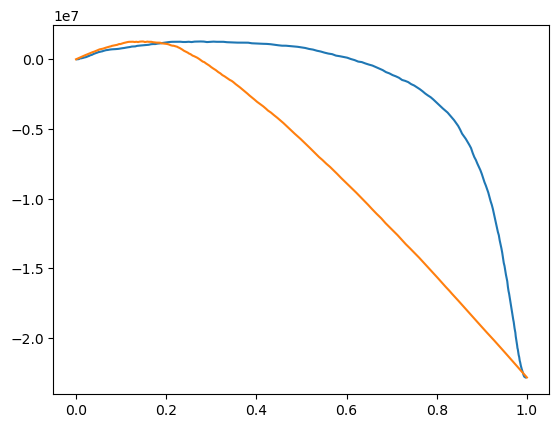

In [97]:
# import numpy as np
# import matplotlib.pyplot as plt
plt.plot(argcumsort['PD'], argcumsort['ProfitCum'])
plt.plot(argcumsort['AR'], argcumsort['ProfitCum'])

In [98]:
argcumsort2=argcumsort.copy()
argcumsort2=argcumsort2.sort_values(by='ProfitCum',ascending=False)
argcumsort2=argcumsort2.reset_index()
print(argcumsort2['ProfitCum'][0])
argcumsort2.head()
#896 902,65

1278193.933117554


,index,PD,Profit,NCum,AR,ProfitCum
0,119,0.276570,1.278194e+06,2200,0.146853,1.278194e+06
1,118,0.269756,1.275034e+06,2156,0.143916,1.275034e+06
2,120,0.283488,1.270564e+06,2248,0.150057,1.270564e+06
3,117,0.263050,1.267524e+06,2121,0.141579,1.267524e+06
4,123,0.304858,1.267344e+06,2373,0.158401,1.267344e+06


In [99]:
# Scoring code

vars_sc=list(pd.unique(Scorecard[variable_name]))

vars_num=Scorecard[Scorecard[type_name]=='INT'].copy()
vars_sc_num=list(pd.unique(vars_num[variable_name]))

vars_nom=Scorecard[Scorecard[type_name]=='NOM'].copy()
vars_sc_nom=list(pd.unique(vars_nom[variable_name]))

with open('scoring_code.sas','w') as f:
    f.write('proc sql; \n')
    f.write('create table  &zbior._score as \n')
    f.write('select indataset.*  \n')
    for var in vars_sc_num:
        scv=Scorecard[Scorecard[variable_name]==var].copy()
        scv=scv.reset_index()
        f.write(', case \n')
        for i in range(scv.shape[0]):
            war=scv[condition_name][i]
            score=scv[score_name][i]
            if war.count('<')==2:
                f.write('when '+war.rsplit('<',1)[0]+' and '+war.rsplit('<=',1)[1]+' then '+str(score)+' \n')
            if war.count('<')==1 and war.count('<>')==0:
                f.write('when '+war+' then '+str(score)+' \n')
            if war.count('= '+symbol_missing)==1:
                f.write('when '+war.split(' ')[0]+' is null then '+str(score)+' \n')
            if war.count('<> '+symbol_missing)==1:
                f.write('when '+war.split(' ')[0]+' is not null then '+str(score)+' \n')
        score=scv[score_name][0]
        f.write('else '+str(score)+' end as PSC_'+var+' \n')
        f.write(' \n')
        
    for var in vars_sc_nom:
        scv=Scorecard[Scorecard[variable_name]==var].copy()
        scv=scv.reset_index()
        f.write(', case \n')
        index_other=0;
        for i in range(scv.shape[0]):
            war=scv[condition_name][i]
            score=scv[score_name][i]
            if war.count(',')==0 and war.count(symbol_other)==0:
                f.write('when '+var+' in ('+"'"+war+"'"+') then '+str(score)+' \n')
            if war.count(',')>0 and war.count(symbol_other)==0:
                f.write('when '+var+' in ('+"'"+war.split(', ')[0]+"'")
                for j in range(war.count(',')):
                    f.write(', '+"'"+war.split(', ')[j+1]+"'")
                f.write(') then '+str(score)+' \n')
            if war.count(symbol_other)==1:
                index_other=i
        score=scv[score_name][index_other]
        f.write('else '+str(score)+' end as PSC_'+var+' \n')
        f.write(' \n')
    
    f.write('/* , 1/(1+exp(-('+str(model_cal.params[0])+'*(0.0')
    for var in vars_sc:            
        f.write('+ calculated PSC_'+var)
    f.write(')+('+str(model_cal.params[1])+')))) as '+prob_event+' */ \n')
    f.write(' \n')
    
    f.write(', 0.0 \n')
    for var in vars_sc:            
        f.write('+ calculated PSC_'+var+' ')
    f.write(' as SCORECARD_POINTS \n')
    
    f.write(' \n')
    f.write('from &zbior as indataset; \n')
    f.write('quit; \n')

In [100]:
#!pip3 install varclushi

In [101]:
#!pip3 install factor_analyzer

In [102]:
# Variable clustering
#from varclushi import VarClusHi

In [103]:
# demo1_df.drop('quality',axis=1,inplace=True)
demo1_vc = VarClusHi(logit_train[vars_selected],maxeigval2=0.1,maxclus=None)
demo1_vc.varclus()

In [104]:
writer = pd.ExcelWriter('Variable_Clustering.xlsx', engine='xlsxwriter')

demo1_vc.info.to_excel(writer, sheet_name='Info', index_label=None, index=False)
demo1_vc.rsquare.to_excel(writer, sheet_name='Clusters', index_label=None, index=False)

writer.save()
writer.close()

/opt/anaconda3/lib/python3.9/site-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [105]:
#!pip3 install shap

In [106]:
#import shap

In [107]:
#!conda install -c conda-forge shap

In [108]:
#!pip3 install numpy==1.23.1

In [109]:
# XAI Explainable artificial intelligence

features=list(result['Efects'][variable_name].copy())
features.remove('Intercept')

# X=logit_train[features]
# y=logit_train[target_name]

X=scored_train[features]
y=scored_train[target_name]

#import shap
logmodel = LogisticRegression()
logmodel.fit(X,y)

for i,v in enumerate(features):
#     logmodel.coef_[0][i]=result['Efects']['Estimation'][i]
    logmodel.coef_[0][i]=1.0
    

logmodel.intercept_=0.0

#explainer=shap.LinearExplainer(logmodel,X)
#shap_values=explainer(X)



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [110]:
 print(logmodel.coef_,logmodel.intercept_)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]] 0.0


In [111]:
#shap.summary_plot(shap_values,X,plot_type='bar')

In [112]:
#shap.plots.bar(shap_values)

In [113]:
#shap.summary_plot(shap_values,X,plot_type='violin')

In [114]:
#shap.plots.beeswarm(shap_values)

In [115]:
#shap.waterfall_plot(shap_values[0])

In [116]:
#shap.initjs()
#shap.plots.force(shap_values[0])

In [117]:
suma=0
for v in features:
    print(v, X[v][0])
    suma=suma+X[v][0]
print('Score',suma)

act_ccss_dueutl 142.0
act_ccss_n_statC 117.0
act_call_cc 137.0
app_loan_amount 117.0
act_cc 136.0
app_number_of_children 126.0
act_cins_n_loan 117.0
app_income 123.0
app_spendings 122.0
act_cins_seniority 117.0
app_char_marital_status_job_code 137.0
act_cins_dueutl 144.0
Score 1535.0


In [118]:
#shap_values[0]

In [119]:
for v in features:
    a=X[v][0]-X[v].mean()
    print(v, a)

act_ccss_dueutl 1.29973297730308
act_ccss_n_statC -16.668891855807743
act_call_cc 8.111481975967962
app_loan_amount -4.095746709898918
act_cc 10.3468434102613
app_number_of_children 0.14257104711043667
act_cins_n_loan -2.9817852374594764
app_income -5.600514972344087
app_spendings -3.4424947549113085
act_cins_seniority -12.337020789624262
app_char_marital_status_job_code 4.744993324432585
act_cins_dueutl 1.767404157924858


In [120]:
XS=X.copy()
XS['sum']=0.0
for v in features:
   XS['sum']=XS['sum']+X[v]

XS['sum'].mean()

1553.7134274270456

In [121]:
#XShap=pd.DataFrame(shap_values.values)
#XShap['sum']=0.0
#for i,v in enumerate(features):
#    XShap['sum']=XShap['sum']+XShap[i]
    
#XShap['sum'].mean()

In [122]:
#a=shap_values.base_values.mean()+XShap['sum'].mean()
#a

In [123]:
# dict = {'gini': [0.73, 0.7299900350659401, 0.7266378402931, 0.7350075157451894, 0.7370777728407707],
#         'profit':[896902.65, 914148.5631010146, 895811.5758456348, 920026.9987934805, 927931.8307756819],
#         'description':["number_vars=15- number_features=6", "number_vars=12 number_features=6", "number_vars=10 number_features=5" "number_vars=15 number_features=7", "number_vars=20 number_features=70.6256871649501146","ncategories_nom=5 - & (Gini_vars[delta_gini]<0.02 - number_vars=12 number_features=6"]}
# df = pd.DataFrame(dict)
 
# # append data frame to CSV file
# df.to_csv('results.csv', index=False)
#description_results = "alp=-alpp.sum()+300 to alp=+alpp.sum()+300"

In [124]:
#df.head()

In [125]:
data = {
    'gini': [gini],
    'profit': [argcumsort2['ProfitCum'][0]],
    'description': [description_results]
}
# Make data frame of above data
df = pd.DataFrame(data)
 
# append data frame to CSV file
#df.to_csv('result.xlsx', mode='a',  header=False)
# append data frame to CSV file
df.to_csv('results.csv', mode='a', index=False, header=False)

In [126]:
#df_results.to_csv('results.csv', index=False)

In [127]:
df_results = pd.read_csv("results.csv")
df_results.head(10)

,0.743400404080832,993996.8944987822,"ncategories_nom=3; 4 new columns; df.drop 4 variables; - vars in ['app','act','agr','ags']- test_size=0.3; Gini_vars[gini_train]>0.06, Gini_vars[delta_gini]<0.3; number_vars=12 number_features=10;"
0,0.738480,9.535179e+05,"ncategories_nom=3; - vars in ['app','act','a..."
1,0.743400,9.939969e+05,NaN
2,0.738480,9.535179e+05,NaN
3,0.743683,9.882337e+05,Gini_vars[gini_train]>0.05
4,0.743400,9.939969e+05,NaN
5,0.763983,1.278194e+06,NaN


In [128]:
# df_results = pd.read_excel("result.xlsx")
# df_results.head(10)

In [129]:
# decorator
def pandas_display(func):
    default_1 = pd.options.display.max_rows
    default_2 = pd.options.display.max_colwidth
    def wrapper(_df, exclude_cols=None, properties=None, limit_float=2):
        pd.options.display.max_rows = 1000
        pd.options.display.max_colwidth = None
        func(_df, exclude_cols, properties, limit_float)
        pd.options.display.max_rows = default_1
        pd.options.display.max_colwidth = default_2
    return wrapper
    
    
@pandas_display
def display_df(self, exclude_cols, properties, limit_float):
    if exclude_cols is not None:
        if not isinstance(exclude_cols, list):
            exclude_cols = list(exclude_cols)
        cols = [x for x in self.columns.values if x not in set(exclude_cols)]
        self = self[cols]

    if not properties:
        properties = {
            'text-align': 'left',
            'white-space': 'pre-wrap',
            'word-wrap': 'break-word',
            'width': '530px',
            'max-width': '530px',
        }
        
    a = self.style.set_properties(**properties)
#     if limit_float is not None:
#         a.format(thousands=',', precision=limit_float)
    display(a)
    
d = display_df
pd.DataFrame.d = d

In [130]:
df_results.d()

,0.743400404080832,993996.8944987822,"ncategories_nom=3; 4 new columns; df.drop 4 variables; - vars in ['app','act','agr','ags']- test_size=0.3; Gini_vars[gini_train]>0.06, Gini_vars[delta_gini]<0.3; number_vars=12 number_features=10;"
0,0.738480,953517.891030,"ncategories_nom=3; - vars in ['app','act','agr','ags']- test_size=0.3; Gini_vars[gini_train]>0.06, Gini_vars[delta_gini]<0.3; number_vars=12 number_features=10;"
1,0.743400,993996.894499,nan
2,0.738480,953517.891030,nan
3,0.743683,988233.696354,Gini_vars[gini_train]>0.05
4,0.743400,993996.894499,nan
5,0.763983,1278193.933118,nan
